In [1]:
import glob
import gzip
import os
import shutil
import sys
import time
import warnings
import zipfile
from datetime import date

import cdsapi
import h5py
import numpy
import numpy as np
import pandas as pd
import urllib3
import xarray

warnings.filterwarnings("ignore")
import pycountry

sys.path.append(os.getcwd() + "/../cds-backend/code/")
import copy
import glob
import json

import csv

import cds_eua4 as eua
import numba
import pandas
import psutil
import requests
from numba import njit


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)


def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref)


import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)
font = {
    "family": "normal",
    # 'weight' : 'bold',
    "size": 22,
}
matplotlib.rc("font", **font)

## CV2

In [2]:
import cv2
import numpy as np
from tkinter import Tk, filedialog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


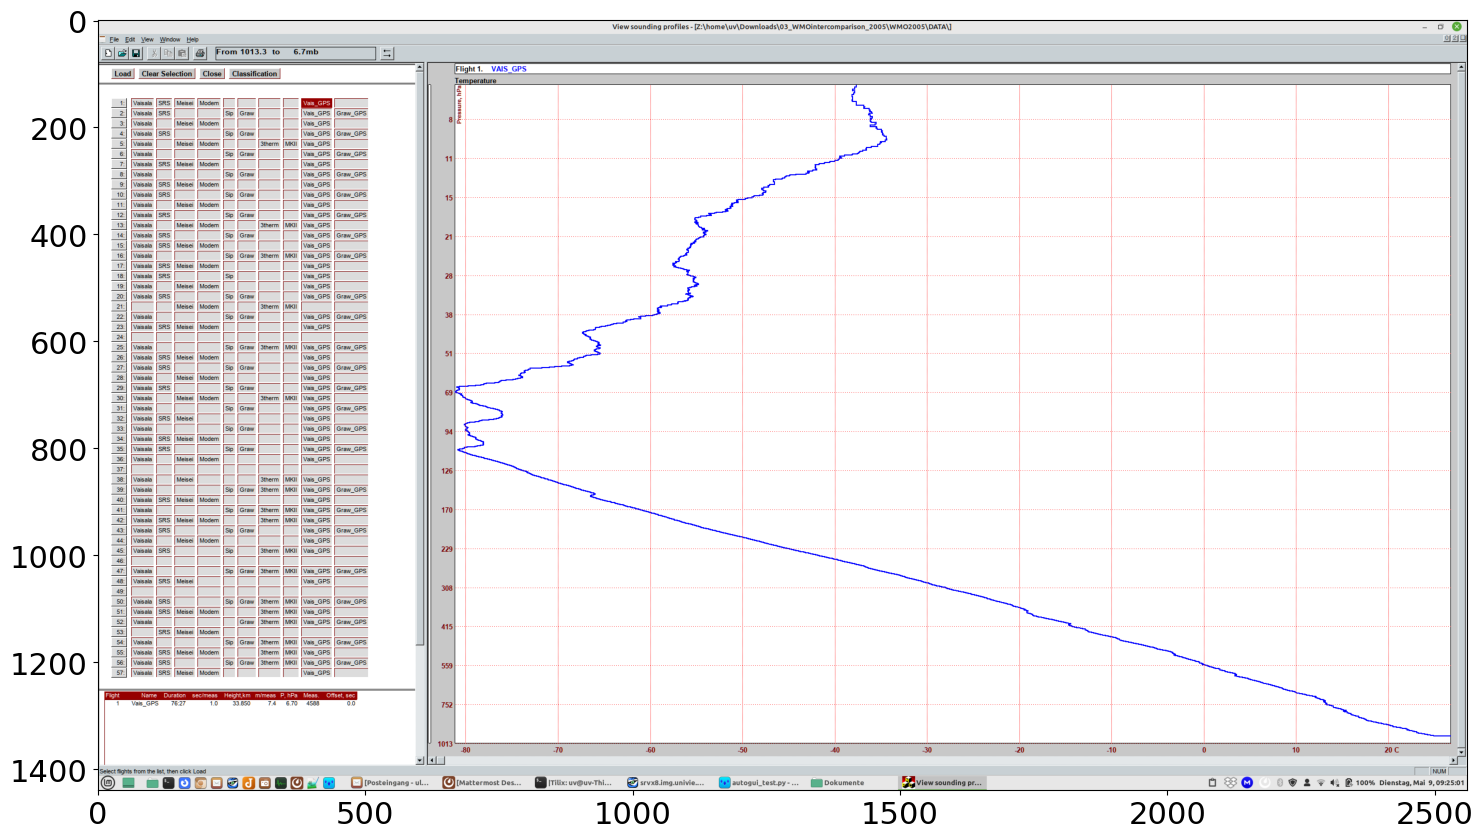

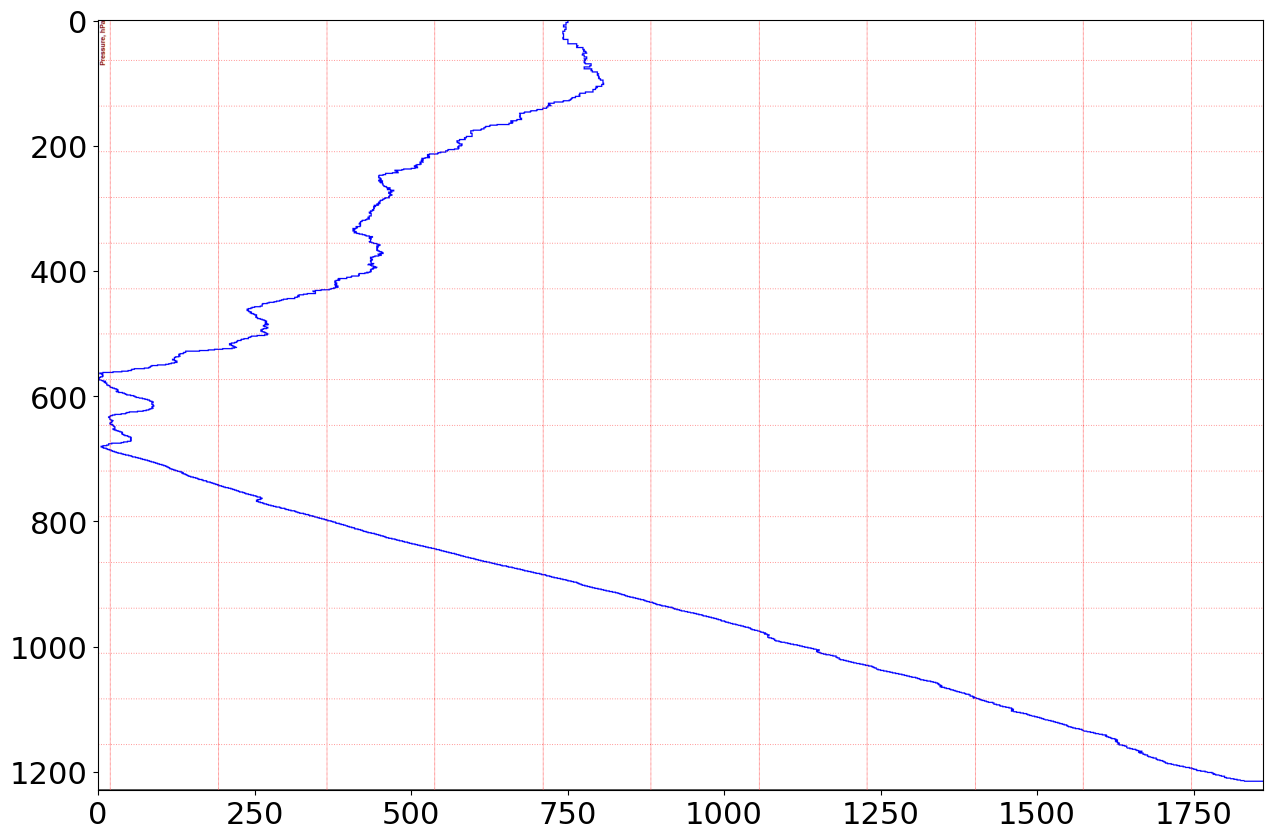

[[695 695 695 ... 698 697 696]
 [113 114 115 ... 113 113 113]]


In [3]:
%matplotlib inline
# Load the image
file = './wview/ascent_data/sc_Vais_GPS_1.png'
img = cv2.imread(file)
plt.imshow(img)
plt.show()
plt.close()

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply a threshold to create a binary image
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find the contours in the binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Find the contour with the largest area (i.e., the plot data)
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding box of the contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the image to the bounding box
plot_only = img[y+10:y+h-1, x+1:x+w-1]

# Save the cropped image
cv2.imwrite('./wview/cropped_images/test_plot_only.png', plot_only)

# Show the cropped image
plt.imshow(plot_only)
plt.show()

# Convert the contour to a numpy array and transpose it
plot_data = largest_contour.squeeze().T

# Print the plot data
print(plot_data)

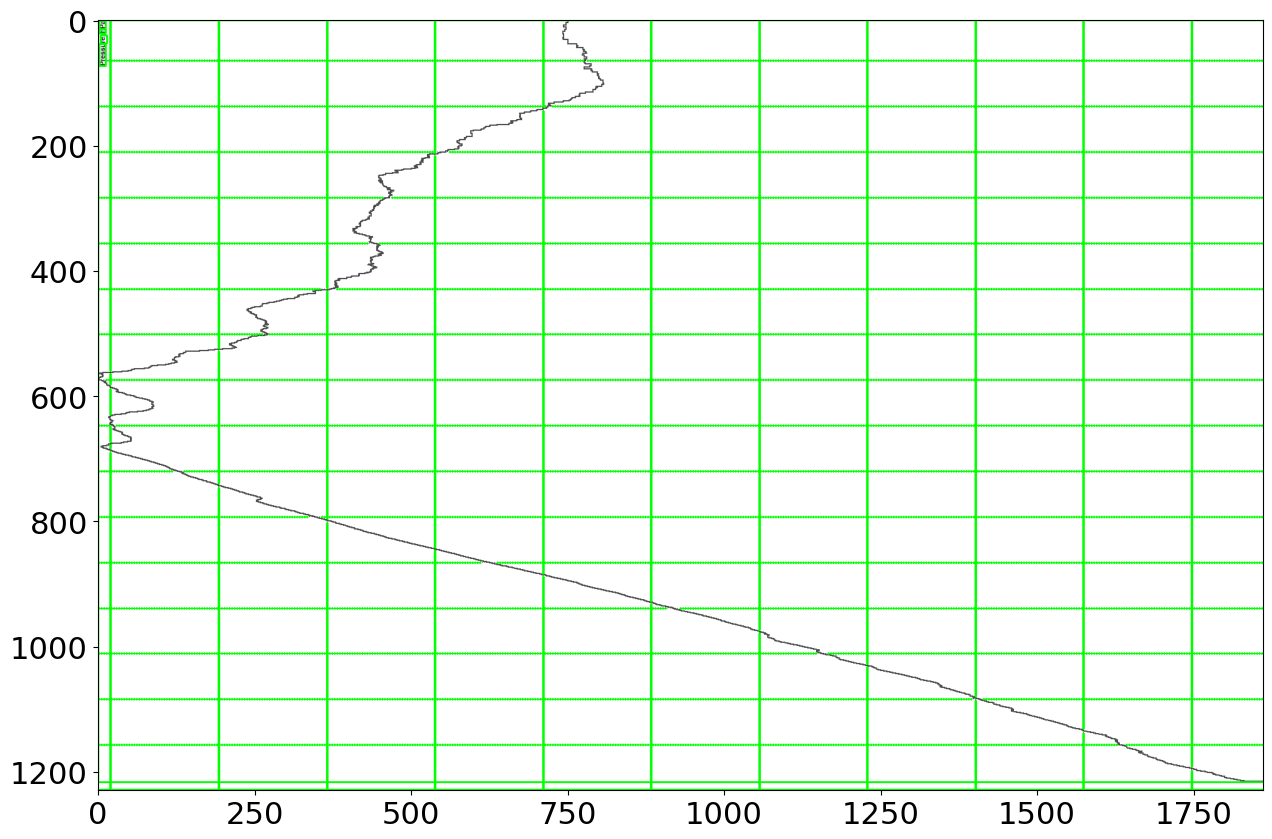

In [4]:
%matplotlib inline

# Read input image as Grayscale
img = cv2.imread('./wview/cropped_images/test_plot_only.png', cv2.IMREAD_GRAYSCALE)

# Convert img to uint8 binary image with values 0 and 255
# All white pixels above 250 goes to 255, and other pixels goes to 0
ret, thresh_gray = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY)

# Inverse polarity
thresh_gray = 255 - thresh_gray


# Find contours in thresh_gray.
contours = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # [-2] indexing takes return value before last (due to OpenCV compatibility issues).

corners = []

# Iterate contours, find bounding rectangles, and add corners to a list
for c in contours:
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(c)

    # Append corner to list of corners - format is corners[i] holds a tuple: ((x0, y0), (x1, y1))
    corners.append(((x, y), (x+w, y+h)))

# Convert grayscale to BGR (just for testing - for drawing rectangles in green color).
out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw green rectangle (for testing)
for c in corners[:]:
    cv2.rectangle(out, c[0], c[1], (0, 255, 0), thickness = 2)
    # print(c)

# cv2.imwrite('out.png', out)  #Save out to file (for testing).


plt.imshow(out)
plt.show()
plt.close()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


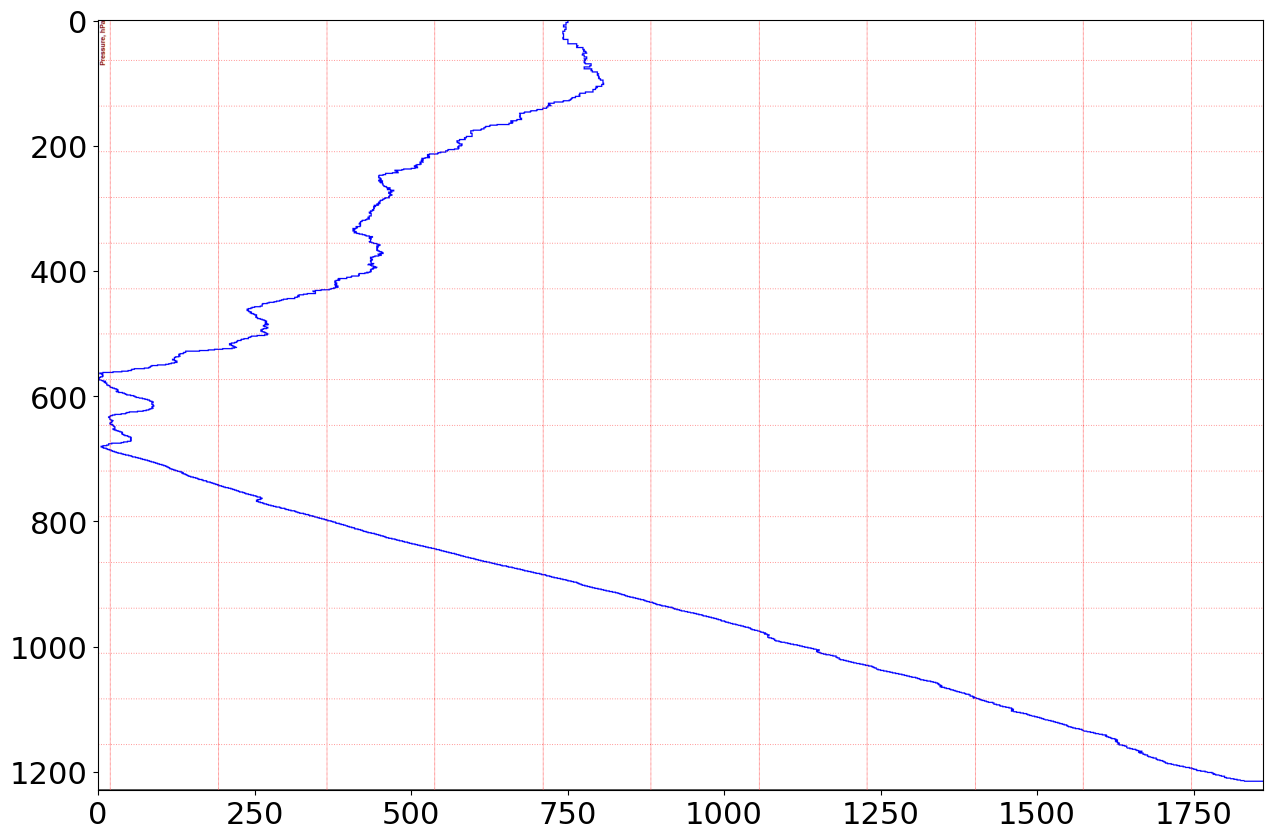

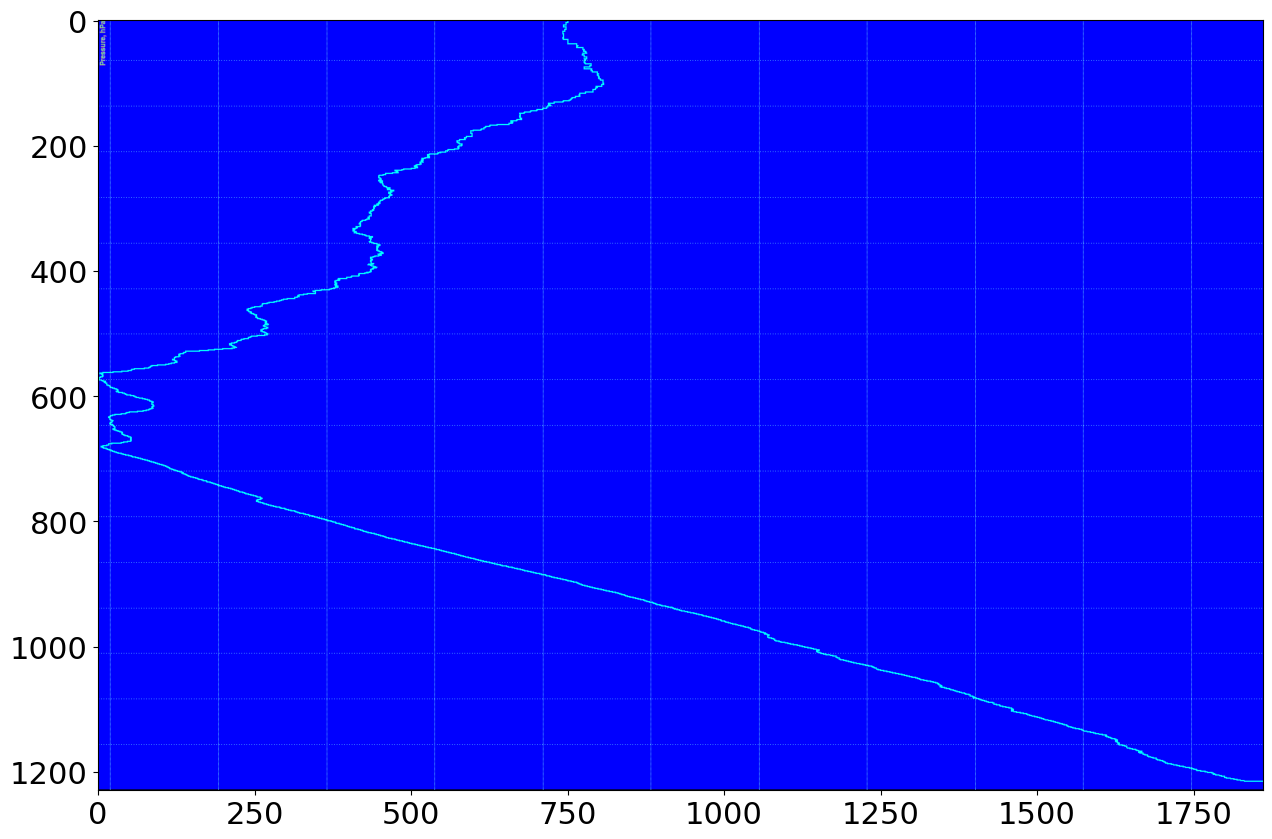

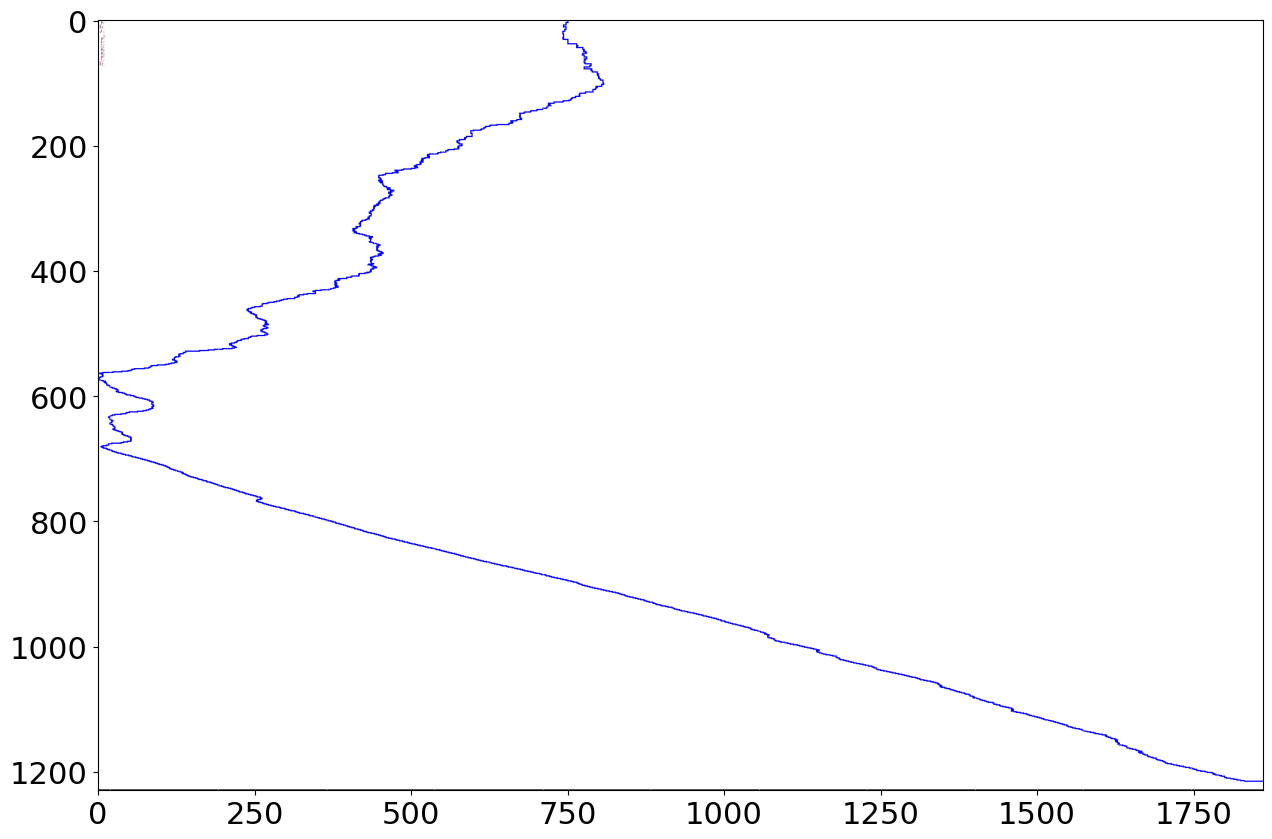

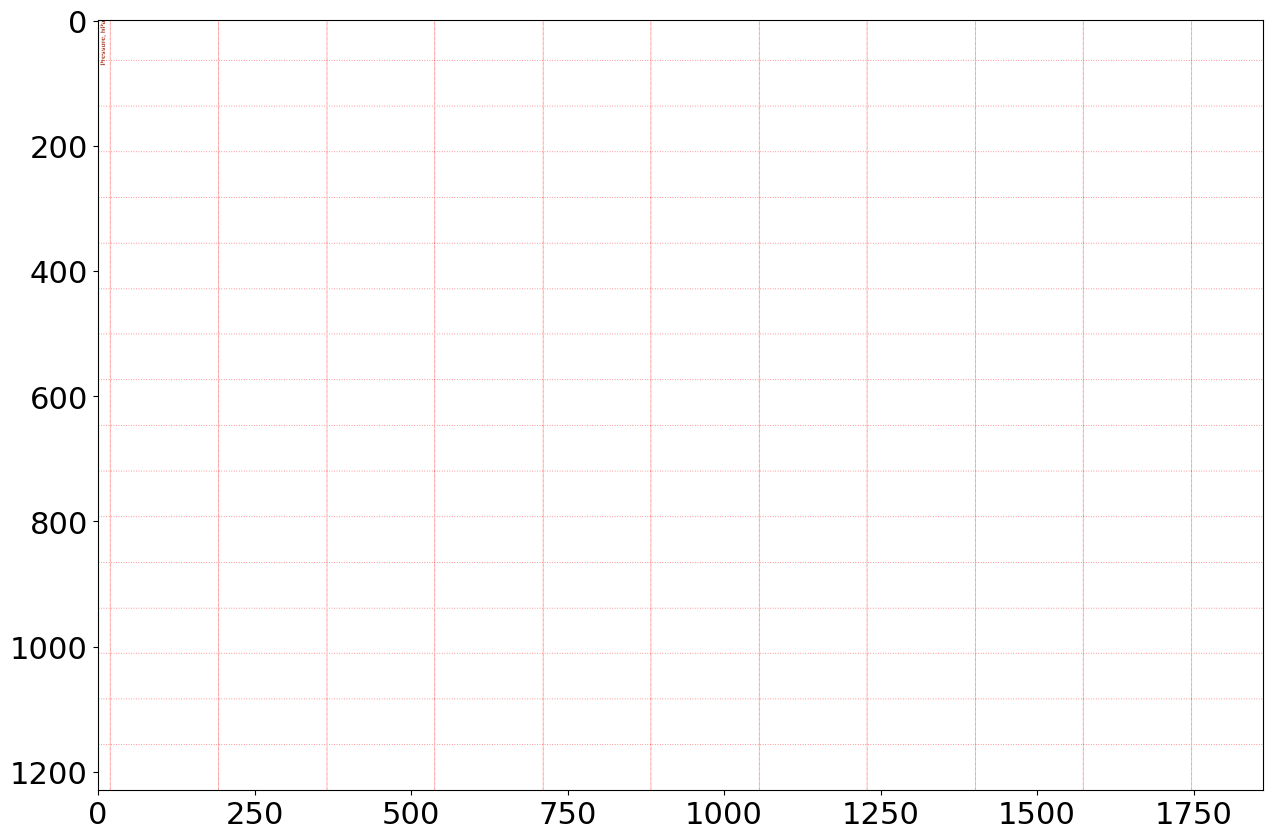

True

In [4]:
colors = {
    "black": [[180, 255, 30], [0, 0, 0]],
    "white": [[180, 18, 255], [0, 0, 231]],
    "red1": [[180, 255, 255], [159, 50, 70]],
    "red2": [[9, 255, 255], [0, 50, 70]],
    "green": [[89, 255, 255], [36, 50, 70]],
    "blue": [[128, 255, 255], [90, 50, 70]],
    "yellow": [[35, 255, 255], [25, 50, 70]],
    "purple": [[158, 255, 255], [129, 50, 70]],
    "orange": [[24, 255, 255], [10, 50, 70]],
    "gray": [[180, 18, 230], [0, 0, 40]],
}

im = cv2.imread("./wview/cropped_images/test_plot_only.png")
plt.imshow(im)
plt.show()
plt.close()

# Define lower and upper limits of our blue
BlueMax = np.array([128, 255, 255], np.uint8)
BlueMin = np.array([90, 50, 70], np.uint8)

# Go to HSV colourspace and get mask of blue pixels
HSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
plt.imshow(HSV)
plt.show()
plt.close()
mask = cv2.inRange(HSV, BlueMin, BlueMax)

# Make all pixels in mask white
grid = copy.copy(im)
grid[mask == 0] = [255, 255, 255]
im[mask > 0] = [255, 255, 255]
plt.imshow(im)
plt.show()
plt.close()
plt.imshow(grid)
plt.show()
plt.close()
cv2.imwrite("./wview/cropped_images/test_grid_only.png", grid)
cv2.imwrite("./wview/cropped_images/test_data_only.png", im)

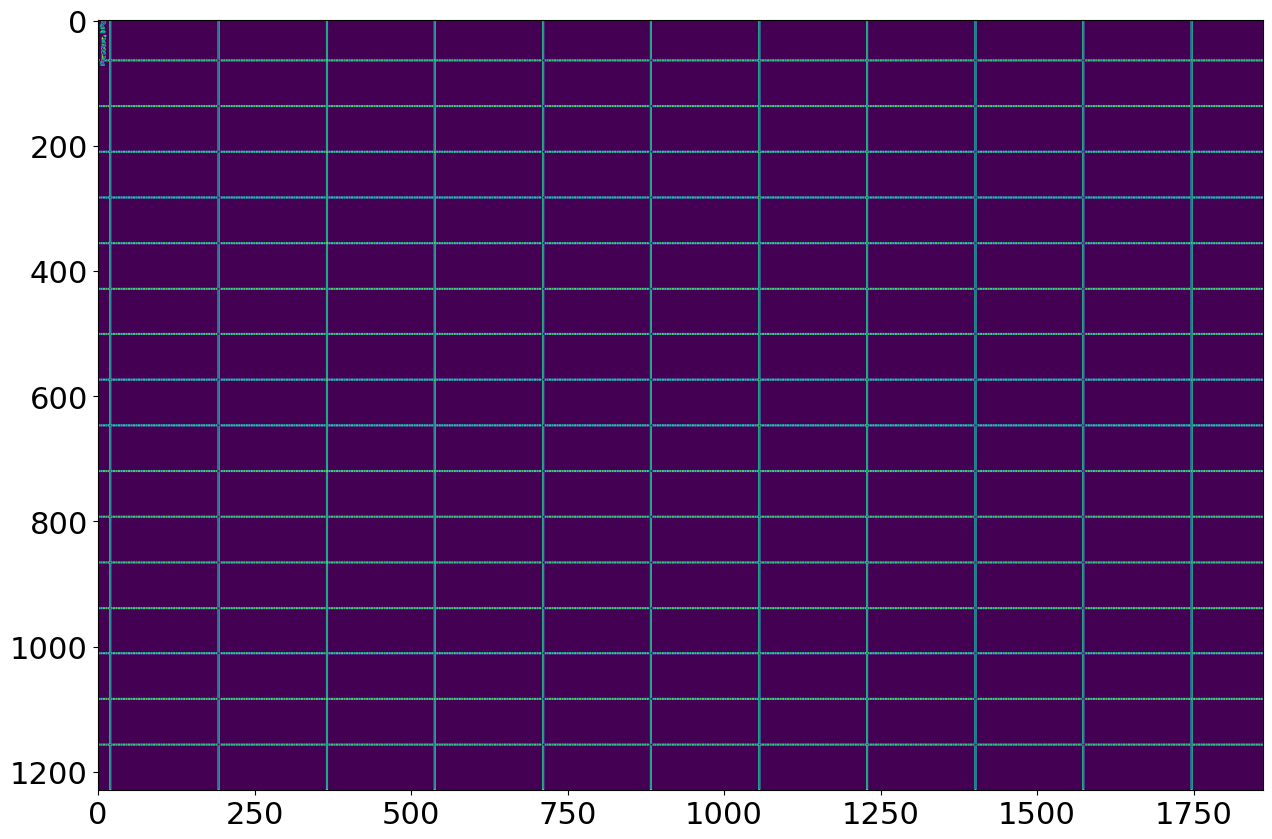

Number of Contours found = 7358


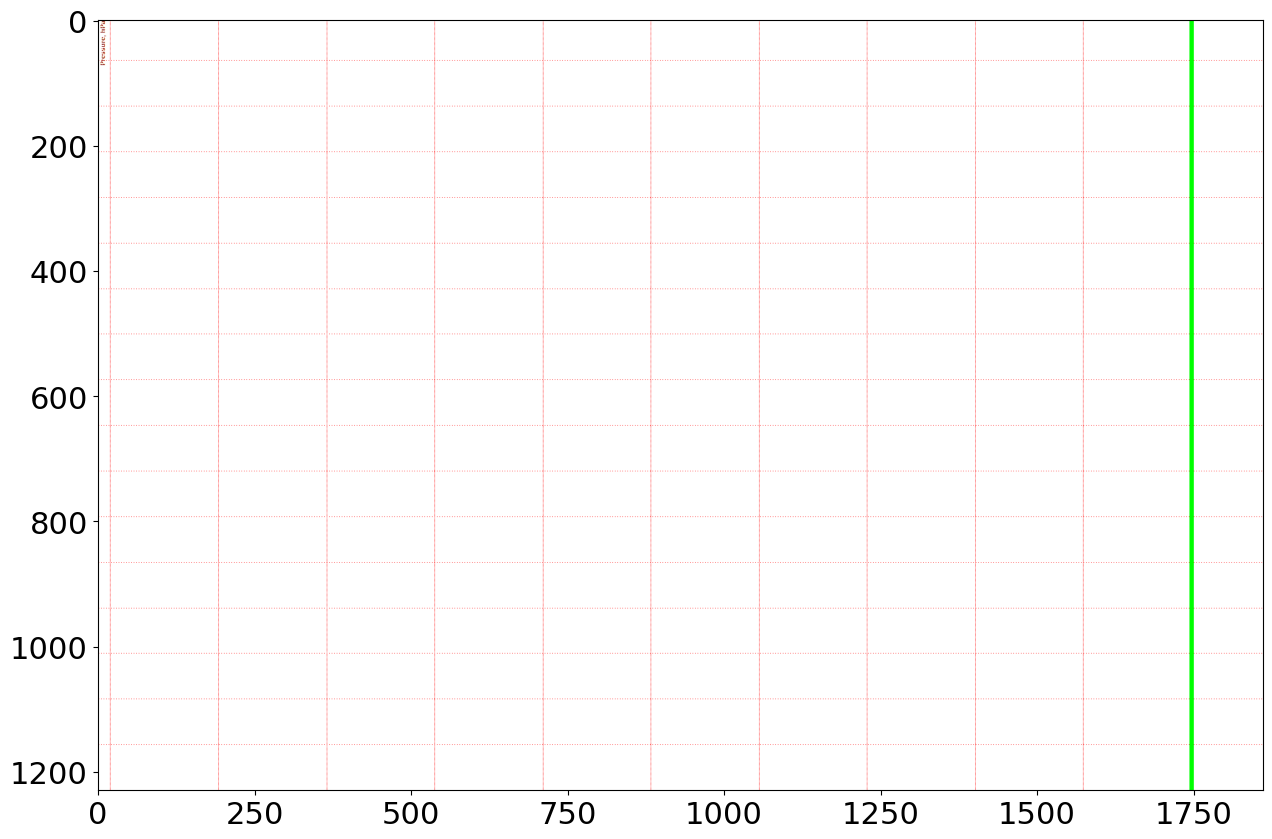

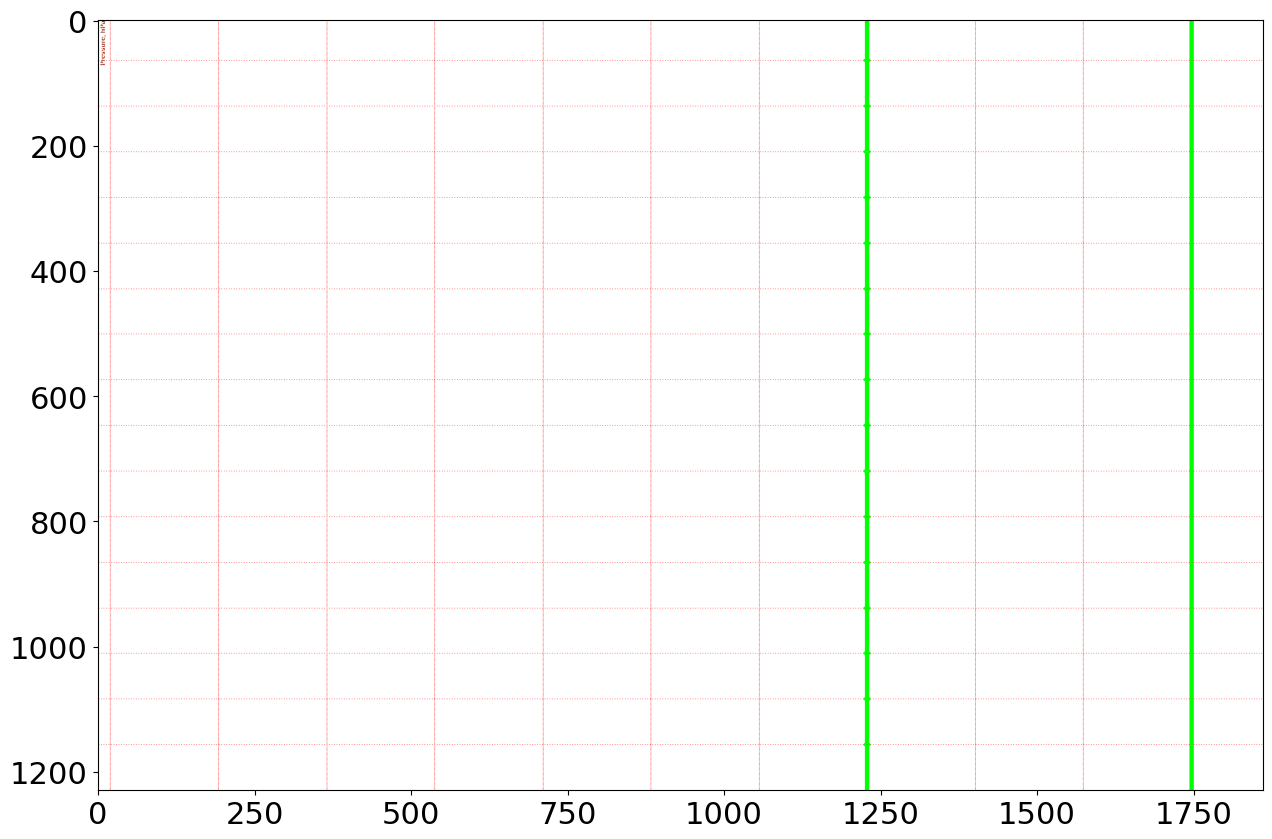

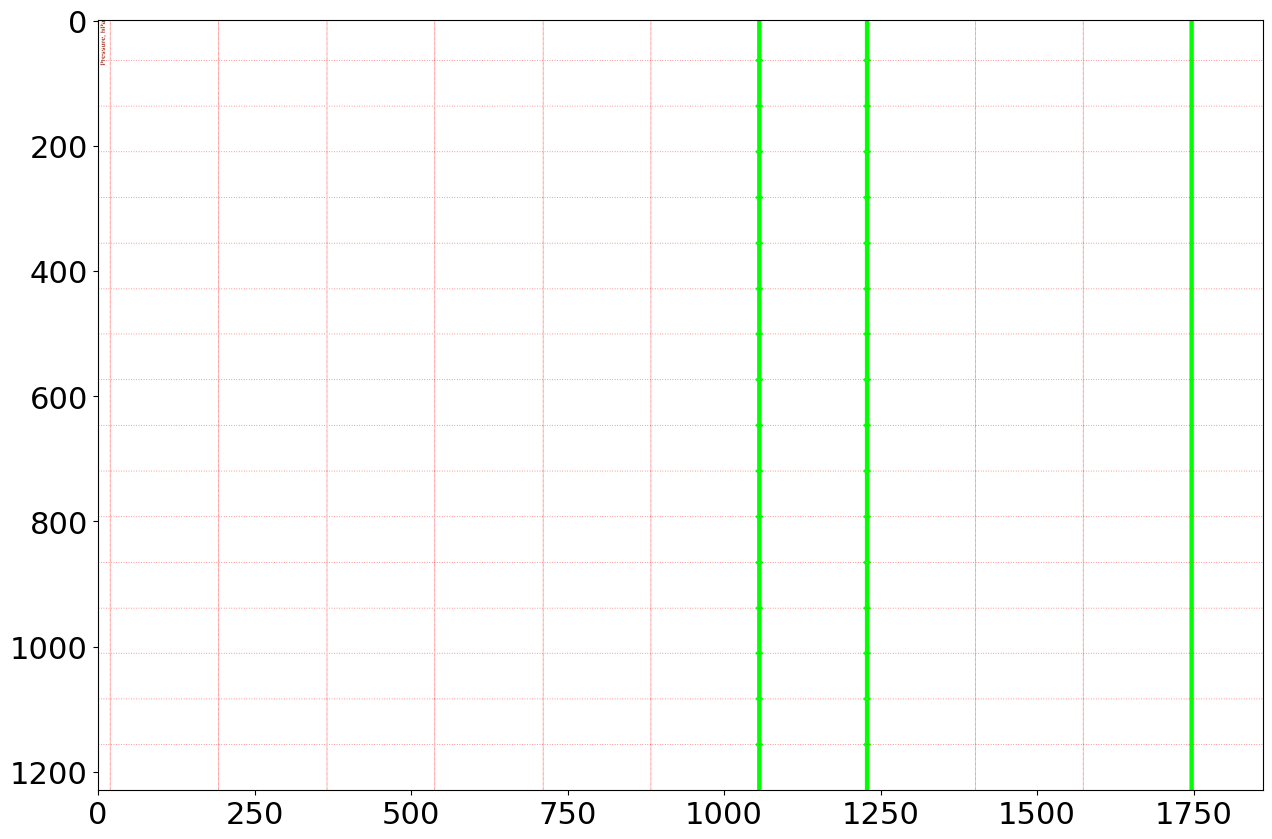

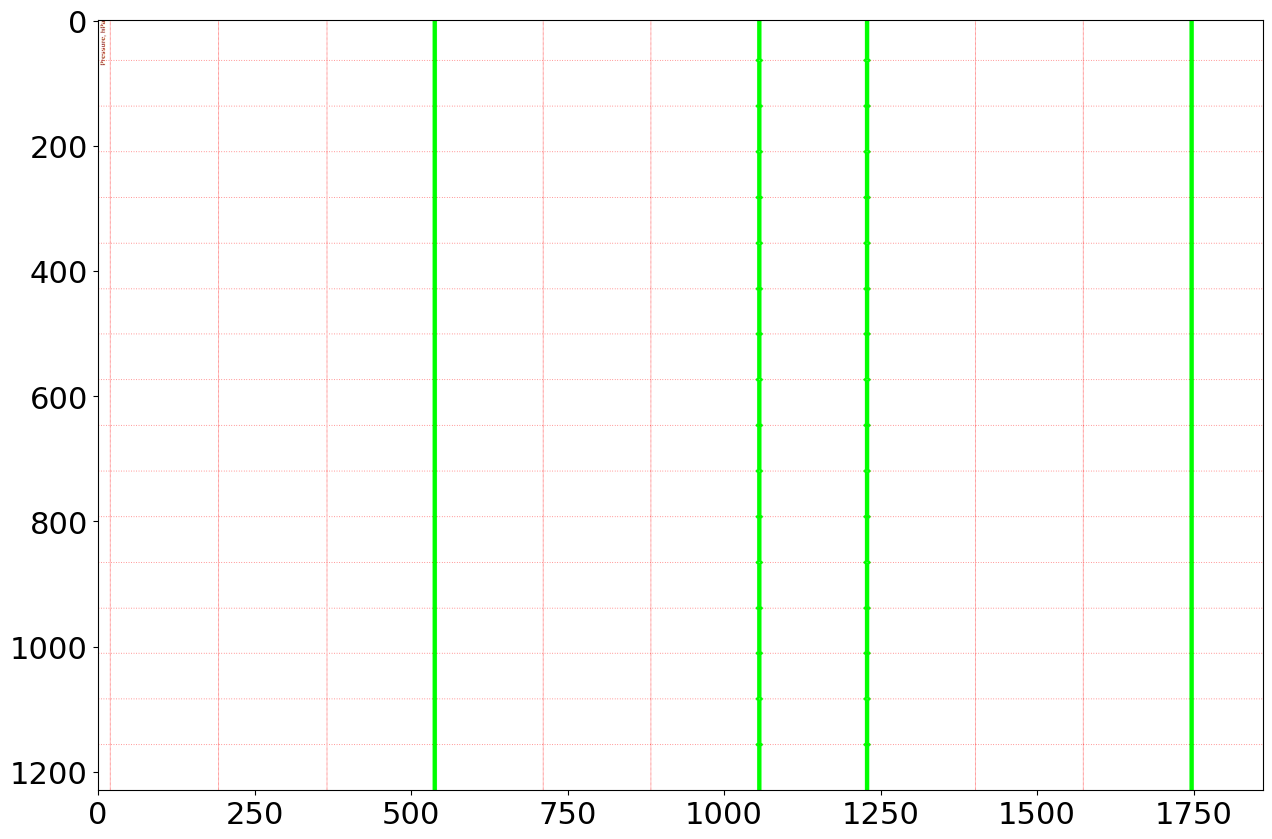

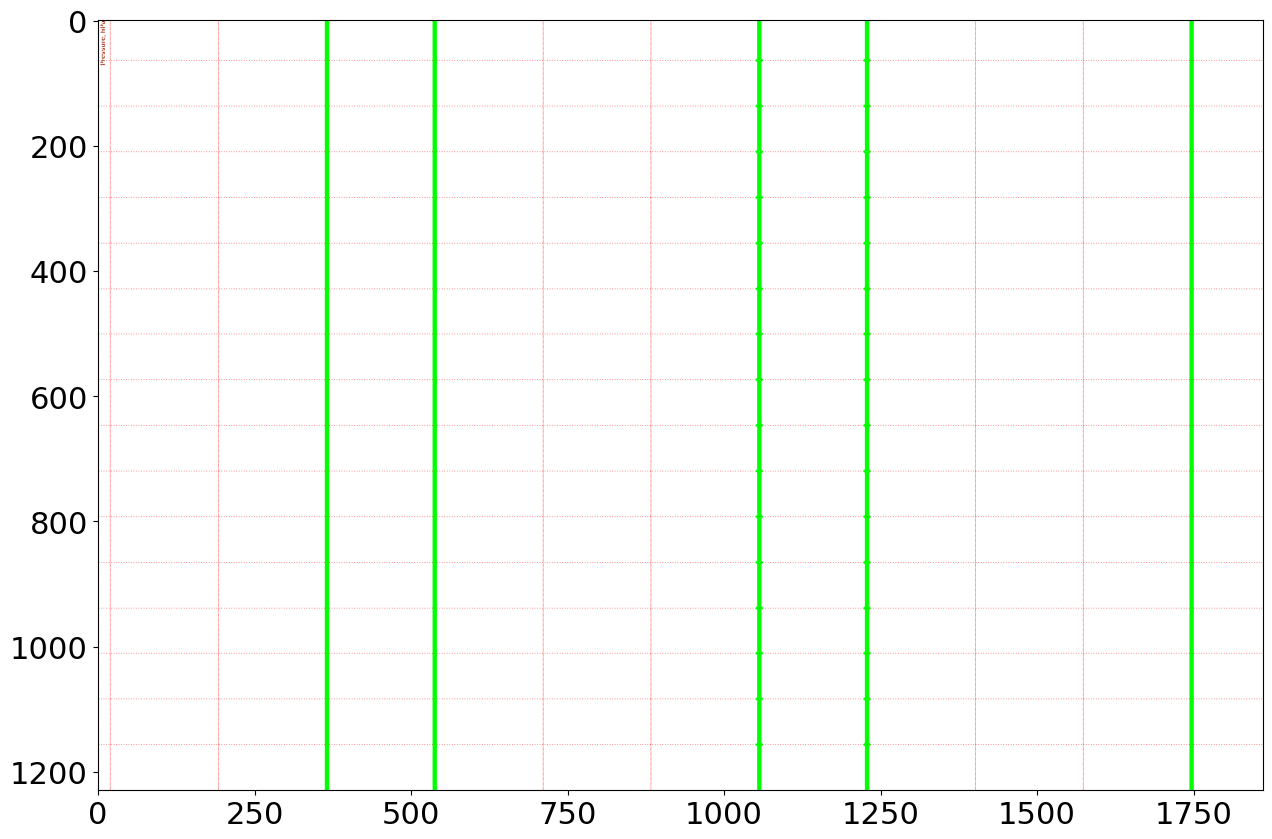

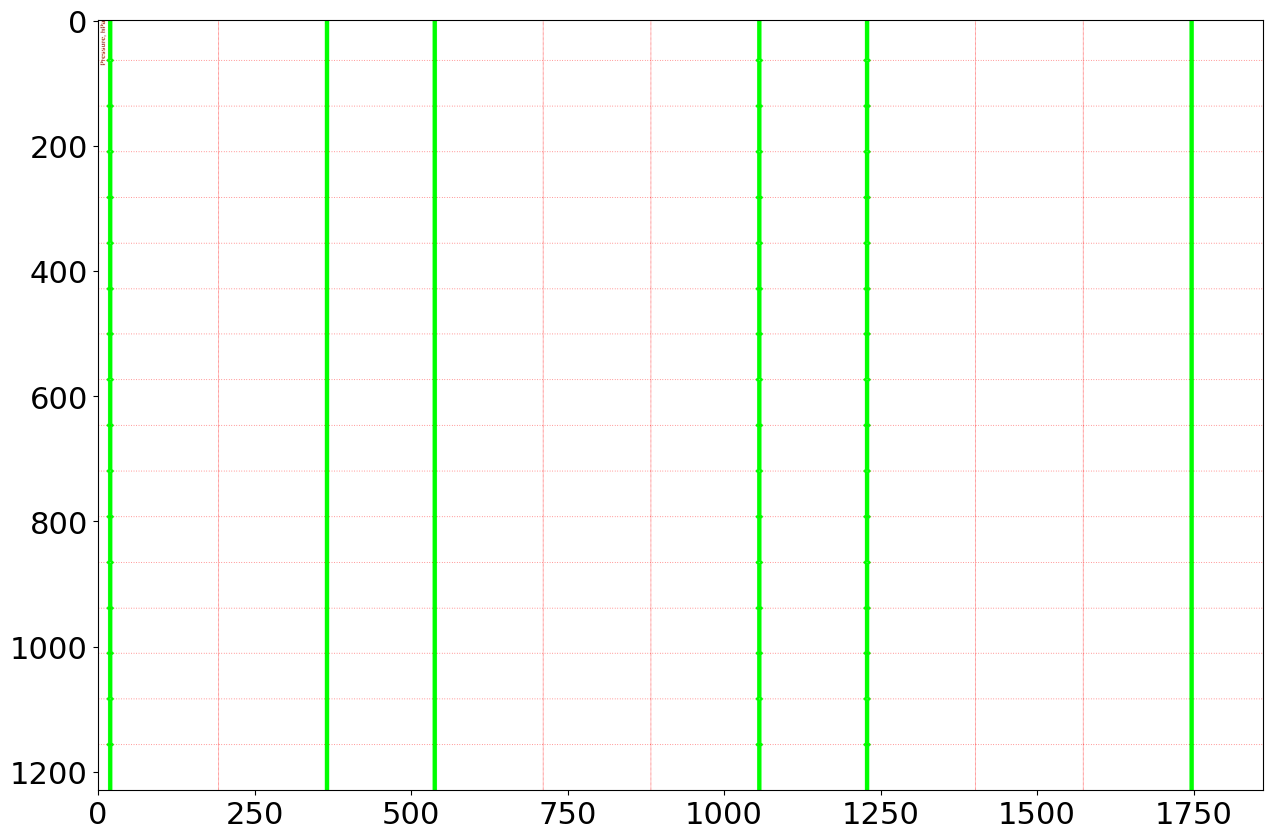

In [21]:
image = cv2.imread('./wview/cropped_images/test_grid_only.png')
  
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
# Find Canny edges
edged = cv2.Canny(gray, 30, 200)
  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
kernel = np.ones((1, 1), np.uint8)
closing = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

contours, hierarchy = cv2.findContours(closing, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
plt.imshow(edged)
plt.show()
plt.close()
  
print("Number of Contours found = " + str(len(contours)))
  
# Draw all contours
# -1 signifies drawing all contours
for c in contours:
    if cv2.contourArea(c) > 20:
        cv2.drawContours(image, c, -1, (0, 255, 0), 3)
        plt.imshow(image)
        plt.show()
        plt.close()


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'contourArea'
> Overload resolution failed:
>  - contour is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'contour'


In [19]:
contours[4][0], contours[5][0]

(array([[1852, 1156]], dtype=int32), array([[1848, 1156]], dtype=int32))

In [10]:
%matplotlib inline

# Read input image as Grayscale
img = cv2.imread('./wview/cropped_images/test_grid_only.png', cv2.IMREAD_GRAYSCALE)
for i in lines[:10]:
    print(i)
    cv2.line(i)


plt.imshow(out)
plt.show()
plt.close()

[[209.          1.5707964]]


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - line() missing required argument 'pt1' (pos 2)
>  - line() missing required argument 'pt1' (pos 2)


In [13]:
lines[:5]

array([[[209.       ,   1.5707964]],

       [[211.       ,   1.5707964]],

       [[355.       ,   1.5707964]],

       [[357.       ,   1.5707964]],

       [[573.       ,   1.5707964]]], dtype=float32)

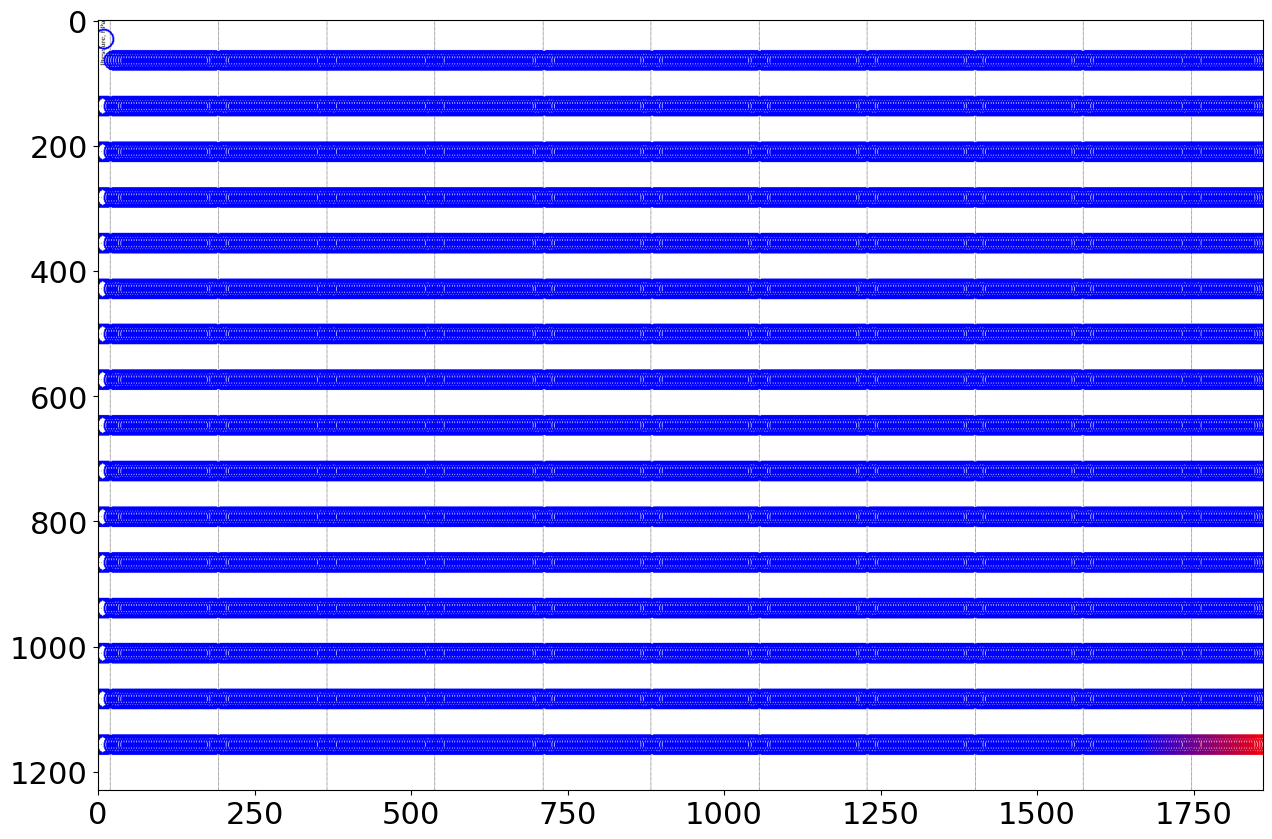

In [22]:
%matplotlib inline

image = cv2.imread('./wview/cropped_images/test_grid_only.png')
  
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
# Find Canny edges
edged = cv2.Canny(gray, 30, 200)
  
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
contours, hierarchy = cv2.findContours(edged, 
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
corners = []

# Check for correct area contours
contourAreas = []
for c in contours:
    area = cv2.contourArea(c)
    if area != 0:
        contourAreas.append(area)
counts = np.bincount(contourAreas)
most_matches_of_same_size = np.argmax(counts)

# Iterate contours, find bounding rectangles, and add corners to a list
for c in contours:
    area = cv2.contourArea(c)
    if area == most_matches_of_same_size:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(c)

        # Append corner to list of corners - format is corners[i] holds a tuple: ((x0, y0), (x1, y1))
        corners.append(((x, y), (x+w, y+h)))

# Convert grayscale to BGR (just for testing - for drawing rectangles in green color).
out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw red point (for testing)
# for c in corners:
#     cv2.rectangle(out, c[0], c[1], (255, 0, 0), thickness = 15)
    
add_c = 0
references = np.mean(corners, axis=1)
for c in references:
    cv2.circle(out, (int(c[0]), int(c[1])), 15, (255-add_c, 0, 0+add_c), thickness = 2)
    add_c += 5
# cv2.imwrite('out.png', out)  #Save out to file (for testing).


plt.imshow(out)
plt.show()
plt.close()

In [23]:
diff_all_x = []
diff_all_y = []
for i in range(len(references)-1):
    diff_all_x.append(np.abs(references[i][0] - references[i+1][0]))
    diff_all_y.append(np.abs(references[i][1] - references[i+1][1]))
    
dx = np.array(diff_all_x, dtype='int')    
dy = np.array(diff_all_y, dtype='int')
counts = np.bincount(dx[dx!=0])
print('x-axis delta = ', np.argmax(counts))
counts = np.bincount(dy[dy!=0])
print('y-axis delta = ', np.argmax(counts))

x-axis delta =  4
y-axis delta =  73


In [99]:
x1 = 0
x2 = 0
y1 = 0
y2 = 0
x_points = 0
y_points = 0
for i in references:
    if x1 == 0 and y1 == 0:
        x1 = i[0]
        y1 = i[1]
    elif x2 == 0:
        x2 = i[0]
    elif i[1] != y1:
        y2 = i[1]
        break
        
print(int(x1), int(x2), int(y1), int(y2))
        
    

2197 1979 1146 1062


usage: ipykernel_launcher.py [-h] -i IMAGE [-c MIN_CONF]
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

In [9]:
! tesseract ./wview/meta_data/meta_0.0.png

Usage:
  tesseract --help | --help-extra | --version
  tesseract --list-langs
  tesseract imagename outputbase [options...] [configfile...]

OCR options:
  -l LANG[+LANG]        Specify language(s) used for OCR.
NOTE: These options must occur before any configfile.

Single options:
  --help                Show this help message.
  --help-extra          Show extra help for advanced users.
  --version             Show version information.
  --list-langs          List available languages for tesseract engine.


In [22]:
import cv2
import pytesseract
! export TESSDATA_PREFIX="/home/swd/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.5.0/tesseract-4.1.1-mr5srxkciiekygolplhcra3idqkqos6y/share/"
pytesseract.pytesseract.tesseract_cmd = "/home/swd/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.5.0/tesseract-4.1.1-mr5srxkciiekygolplhcra3idqkqos6y/bin/tesseract"

# Grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('./wview/meta_data/meta_0.0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Perform text extraction
data = pytesseract.image_to_string(invert, lang='eng', config='--psm 6')
print(data)

TesseractError: (1, 'Error opening data file /home/swd/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.5.0/tesseract-4.1.1-mr5srxkciiekygolplhcra3idqkqos6y/share/tessdata/eng.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'eng\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

In [ ]:
### measure via gimp -> correct

In [ ]:
# find relativ position to uncut -> so text selection is possible

In [100]:
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/users/staff/uvoggenberger/'

In [102]:
img_cv = cv2.imread('./interc_2005/test_screen_shot.png')
# By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
# we need to convert from BGR to RGB format/mode:
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
print(pytesseract.image_to_string(img_rgb))

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [104]:
# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r"/home/swd/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.5.0/tesseract-4.1.1-mr5srxkciiekygolplhcra3idqkqos6y/"
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

# Simple image to string
print(pytesseract.image_to_string(Image.open("test.png")))

PermissionError: [Errno 13] Permission denied: '/home/swd/spack/opt/spack/linux-rhel8-skylake_avx512/gcc-8.5.0/tesseract-4.1.1-mr5srxkciiekygolplhcra3idqkqos6y/'

## img to data:

https://github.com/dilawar/PlotDigitizer

https://pypi.org/project/pytesseract/

https://nanonets.com/blog/ocr-with-tesseract/

In [2]:
ingested_data = glob.glob('./interc_2005/*_02_ta.csv')
ingested_data

['./interc_2005/graw_02_ta.csv',
 './interc_2005/sip_02_ta.csv',
 './interc_2005/srs_02_ta.csv',
 './interc_2005/vaisgps_02_ta.csv']

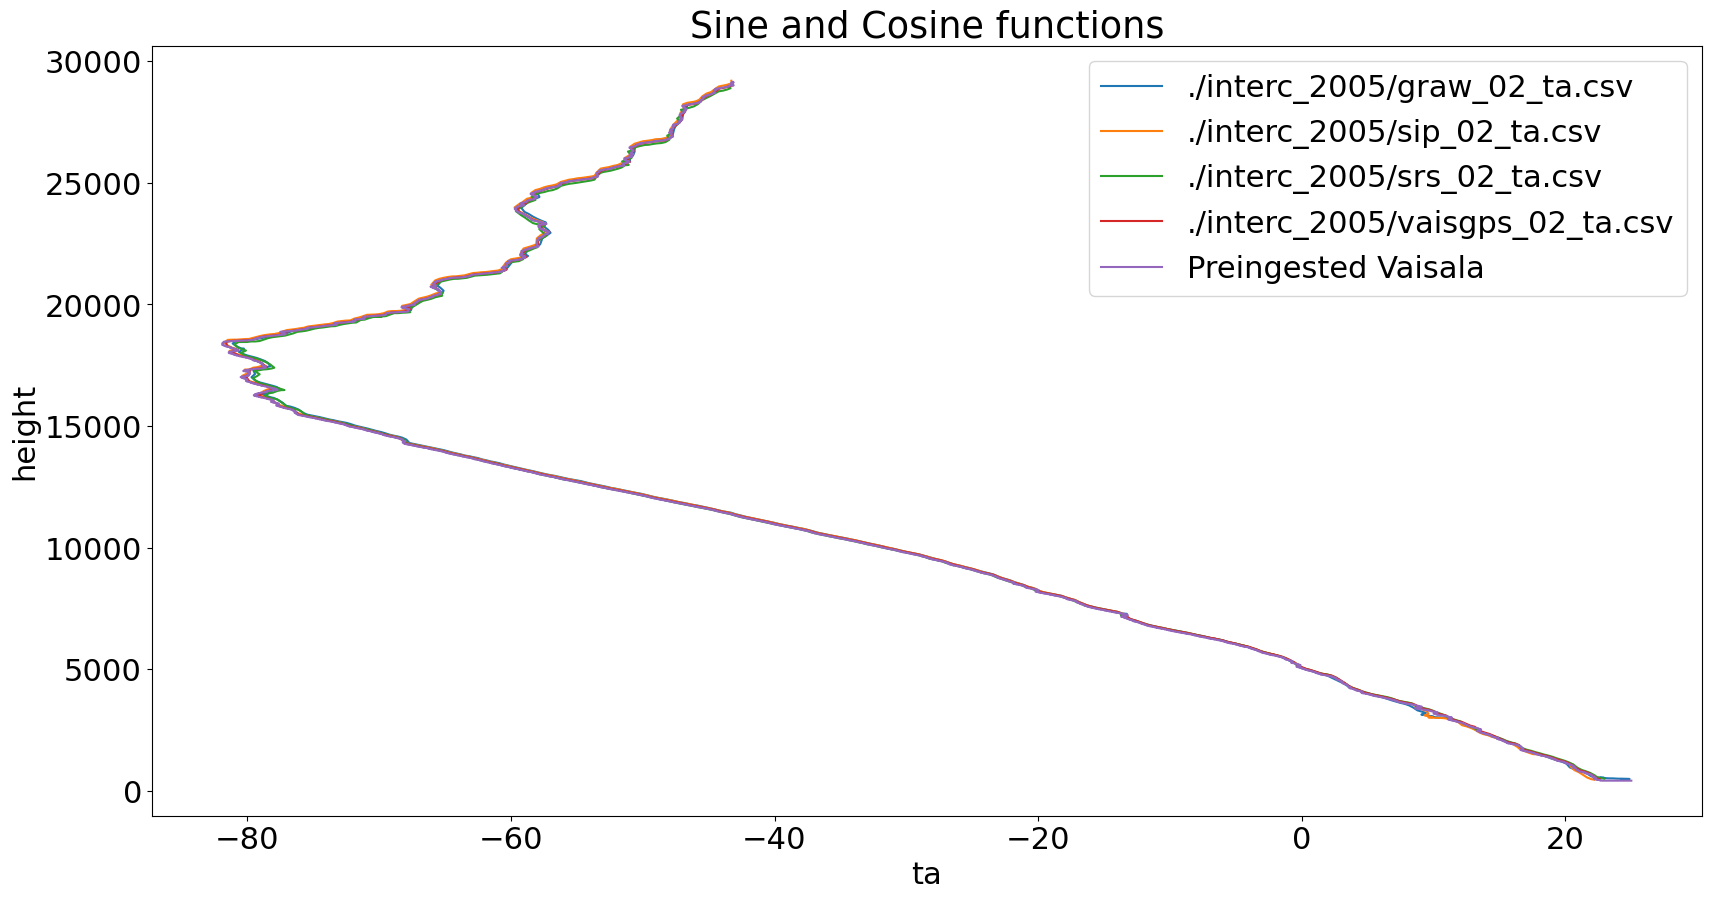

In [28]:
datasets = []
for i in ingested_data:
    df = pd.read_csv(i, delimiter='; ', decimal=',', names=['ta', 'z'])
    # print(i)
    # display(df)
    plt.plot(df.ta, df.z, label=i)
    
vais_df = pd.read_csv('./vaisala_ascents.csv')
vais_df = vais_df[vais_df.date_time == "07-02-2005 14:57:50.481"]
vais_df = vais_df[vais_df.height > 0]
plt.plot(vais_df.temperature, vais_df.height, label='Preingested Vaisala')#, alpha = 0.4, linewidth = 6)
    
plt.xlabel("ta")
plt.ylabel("height")
plt.title("Sine and Cosine functions")
plt.legend()
plt.show()

## target file structure

In [10]:
comp_files = glob.glob("/users/staff/uvoggenberger/scratch/comp/*.nc")
comp_files[0]

'/users/staff/uvoggenberger/scratch/comp/0-20100-0-00201_CEUAS_merged_v0.nc'

In [98]:
for i in comp_files[:3]:
    print(i)
    with eua.CDMDataset(i) as file:
        # display(file)
        # display(file['observations_table'])
        # sensors = np.array(file['observations_table']['sensor_id'][:])
        df = file.to_dataframe(
            groups=["observations_table"],
            variables=["sensor_id", "z_coordinate", "date_time", "observed_variable", "observation_value"],
        )
        display(df)
        print()

/users/staff/uvoggenberger/scratch/comp/0-20100-0-00201_CEUAS_merged_v0.nc


,sensor_id,z_coordinate,date_time,observed_variable,observation_value
0,"FM2,FH_ ,FME",5000.0,1950-05-10 15:29:00,38,NaN
1,"FM2,FH_ ,FME",5300.0,1950-05-10 15:28:00,38,NaN
2,"FM2,FH_ ,FME",5600.0,1950-05-10 15:27:00,38,NaN
3,"FM2,FH_ ,FME",5900.0,1950-05-10 15:26:00,38,NaN
4,"FM2,FH_ ,FME",6200.0,1950-05-10 15:25:00,38,NaN
...,...,...,...,...,...
3157,"FM2,FH_ ,FME",80100.0,1950-05-26 21:12:00,117,NaN
3158,"FM2,FH_ ,FME",84000.0,1950-05-26 21:11:00,117,NaN
3159,"FM2,FH_ ,FME",87700.0,1950-05-26 21:10:00,117,NaN
3160,"FM2,FH_ ,FME",91800.0,1950-05-26 21:09:00,117,NaN



/users/staff/uvoggenberger/scratch/comp/0-20100-0-00202_CEUAS_merged_v0.nc


,sensor_id,z_coordinate,date_time,observed_variable,observation_value
0,S03,25900.0,1950-05-10 14:55:00,38,NaN
1,S03,27500.0,1950-05-10 14:54:00,38,NaN
2,S03,29000.0,1950-05-10 14:53:00,38,NaN
3,S03,30700.0,1950-05-10 14:52:00,38,NaN
4,S03,32500.0,1950-05-10 14:51:00,38,NaN
...,...,...,...,...,...
2830,S03,80500.0,1950-05-26 21:12:00,117,18926.64150
2831,S03,84500.0,1950-05-26 21:11:00,117,15102.08700
2832,S03,88300.0,1950-05-26 21:10:00,117,11571.72900
2833,S03,91900.0,1950-05-26 21:09:00,117,8335.56750



/users/staff/uvoggenberger/scratch/comp/0-20100-0-00203_CEUAS_merged_v0.nc


,sensor_id,z_coordinate,date_time,observed_variable,observation_value
0,"VU_,V_",31700.0,1950-05-10 21:51:00,38,NaN
1,"VU_,V_",33300.0,1950-05-10 21:50:00,38,NaN
2,"VU_,V_",35300.0,1950-05-10 21:49:00,38,NaN
3,"VU_,V_",36900.0,1950-05-10 21:48:00,38,NaN
4,"VU_,V_",39200.0,1950-05-10 21:47:00,38,NaN
...,...,...,...,...,...
2917,"VU_,V_",80100.0,1950-05-26 21:12:00,117,NaN
2918,"VU_,V_",83600.0,1950-05-26 21:11:00,117,NaN
2919,"VU_,V_",87400.0,1950-05-26 21:10:00,117,NaN
2920,"VU_,V_",92600.0,1950-05-26 21:09:00,117,NaN


In [95]:
df

,sensor_id,z_coordinate,date_time,observed_variable,observation_value
0,"FM2,FH_ ,FME",5000.0,1950-05-10 15:29:00,38,NaN
1,"FM2,FH_ ,FME",5300.0,1950-05-10 15:28:00,38,NaN
2,"FM2,FH_ ,FME",5600.0,1950-05-10 15:27:00,38,NaN
3,"FM2,FH_ ,FME",5900.0,1950-05-10 15:26:00,38,NaN
4,"FM2,FH_ ,FME",6200.0,1950-05-10 15:25:00,38,NaN
...,...,...,...,...,...
3157,"FM2,FH_ ,FME",80100.0,1950-05-26 21:12:00,117,NaN
3158,"FM2,FH_ ,FME",84000.0,1950-05-26 21:11:00,117,NaN
3159,"FM2,FH_ ,FME",87700.0,1950-05-26 21:10:00,117,NaN
3160,"FM2,FH_ ,FME",91800.0,1950-05-26 21:09:00,117,NaN


In [93]:
np.unique(sensors, axis=0)

array([[b'F', b'M', b'2', b',', b'F', b'H', b'_', b' ', b',', b'F', b'M',
        b'E', b' ']], dtype='|S1')

## codec to read header

In [31]:
codec = pd.read_csv('./interc_2005/codec.csv')
codec

,Codec,Aliases,Languages
0,ascii,"646, us-ascii",English
1,big5,"big5-tw, csbig5",Traditional Chinese
2,big5hkscs,"big5-hkscs, hkscs",Traditional Chinese
3,cp037,"IBM037, IBM039",English
4,cp273,"273, IBM273, csIBM273",German New in version 3.4.
...,...,...,...
92,utf_16_be,UTF-16BE,all languages
93,utf_16_le,UTF-16LE,all languages
94,utf_7,"U7, unicode-1-1-utf-7",all languages
95,utf_8,"U8, UTF, utf8, cp65001",all languages


## correct meaning of columns?

In [46]:
vais_mau = pd.read_excel("./interc_2005/Mauritius_2005_Vaisala.xlsx")

In [47]:
df = vais_mau.dropna(axis=1, how='all')
df

,Time = 10:01:53.551,Time = 14:57:50.481,Time = 19:31:41.965,Time = 05:13:16.722,Time = 10:00:56.553,Time = 15:03:03.289,Time = 19:33:03.372,Time = 05:12:00.618,Time = 10:05:05.418,Date = 14:59:48.197,...,Time = 18:23:00.860,Time = 05:02:40.940,Time = 10:02:01.112,Time = 15:01:31.734,Time = 05:03:32.669,Time = 10:03:25.750,Time = 15:01:16.195,Time = 18:04:29.389,Time = 05:04:54.828,Time = 10:17:06.975
0,Date = 07-02-2005,Date = 07-02-2005,Date = 07-02-2005,Date = 08-02-2005,Date = 08-02-2005,Date = 08-02-2005,Date = 08-02-2005,Date = 09-02-2005,Date = 09-02-2005,Time = 09-02-2005,...,Date = 22-02-2005,Date = 23-02-2005,Date = 23-02-2005,Date = 23-02-2005,Date = 24-02-2005,Date = 24-02-2005,Date = 24-02-2005,Date = 24-02-2005,Date = 25-02-2005,Date = 25-02-2005
1,0 961.6 28.5 71 425 60 6.2 425,0 962.6 25.0 86 425 85 4.6 425,0 963.5 23.4 96 425 85 4.1 425,0 963.3 24.8 91 425 70 5.0 425,0 962.2 27.0 78 425 60 6.7 425,0 961.6 23.2 94 425 80 5.1 425,0 963.0 23.2 96 425 80 5.1 425,0 963.9 23.9 96 425 60 4.6 425,0 963.4 26.4 79 425 50 4.6 425,0 963.0 23.7 95 425 70 4.1 425,...,0 961.5 23.1 96 425 0 0.0 425,0 961.3 26.9 71 425 200 1.0 425,0 959.5 29.3 65 425 180 2.6 425,0 959.4 25.4 81 425 190 1.5 425,0 961.0 26.6 76 425 180 2.0 425,0 959.8 25.0 91 425 210 2.0 425,0 958.7 24.0 90 425 130 1.0 425,0 961.2 22.7 96 425 0 0.0 425,0 962.1 26.1 77 425 260 1.0 425,0 961.1 28.2 70 425 270 2.6 425
2,1 961.2 26.7 74 428 61 5.1 431,1 962.2 22.9 89 429 73 4.7 423,1 963.0 23.3 96 429 77 3.9 428,1 962.8 23.2 92 430 53 4.9 435,1 961.5 24.0 85 431 43 5.6 432,1 961.3 23.3 95 428 72 4.8 429,1 962.2 22.8 96 432 72 4.4 433,1 963.1 23.7 93 432 58 4.8 430,1 962.2 26.0 81 436 51 4.6 430,1 962.7 23.4 95 428 63 3.8 420,...,1 960.6 23.3 95 433 257 0.6 429,1 960.7 24.9 73 431 172 1.6 432,1 959.1 27.6 61 429 188 3.1 431,1 959.1 24.1 85 427 168 1.6 430,1 959.9 25.8 73 435 183 2.2 430,1 959.2 23.7 89 431 209 1.7 428,1 958.4 23.1 91 428 129 1.5 429,1 960.9 22.8 96 427 95 0.5 426,1 961.4 24.9 67 431 267 0.6 426,1 960.4 26.3 72 431 281 2.4 431
3,2 960.8 25.2 75 433 62 4.8 436,2 961.7 22.8 92 433 65 4.9 425,2 962.5 23.2 97 434 74 4.0 434,2 962.2 23.2 93 435 45 5.1 443,2 960.9 23.9 89 437 34 5.2 438,2 960.9 23.4 96 432 69 5.0 434,2 961.7 22.8 96 437 68 4.1 439,2 962.5 23.6 92 438 56 5.2 435,2 961.5 25.8 81 443 51 4.7 434,2 962.3 23.3 95 431 61 4.0 417,...,2 959.9 23.5 95 440 216 0.9 436,2 960.1 24.8 75 436 162 1.9 439,2 958.8 26.8 60 432 192 3.5 437,2 958.9 24.0 87 430 156 1.8 436,2 959.1 25.7 71 442 184 2.4 435,2 958.6 23.6 88 436 208 1.7 430,2 958.1 23.1 91 430 129 1.8 434,2 960.6 23.0 96 431 145 0.8 427,2 960.8 24.9 68 437 360 0.5 429,2 959.8 26.3 73 437 288 2.3 437
4,3 960.2 25.0 76 437 62 5.0 439,3 961.2 22.7 93 438 61 5.2 429,3 961.9 23.1 97 440 74 4.2 440,3 961.6 23.1 93 440 43 5.5 449,3 960.3 23.8 91 443 31 5.2 445,3 960.3 23.4 96 437 68 5.3 440,3 961.3 22.7 96 441 67 4.3 444,3 961.8 23.5 92 444 55 5.5 439,3 961.0 25.6 81 447 50 4.9 437,3 961.9 23.2 95 435 60 4.3 421,...,3 959.3 23.5 95 445 206 1.1 443,3 959.5 24.8 75 441 160 2.0 445,3 958.5 26.7 60 434 193 3.8 442,3 958.5 24.0 89 433 152 1.9 440,3 958.5 25.6 70 448 184 2.5 440,3 958.2 23.6 88 440 208 1.8 432,3 957.7 23.1 91 434 129 2.0 440,3 960.2 23.3 95 435 159 1.0 430,3 960.2 24.8 69 442 360 0.5 434,3 959.2 26.3 73 442 289 2.3 445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df.keys()

Index(['Time = 10:01:53.551', 'Time = 14:57:50.481', 'Time = 19:31:41.965',
       'Time = 05:13:16.722', 'Time = 10:00:56.553', 'Time = 15:03:03.289',
       'Time = 19:33:03.372', 'Time = 05:12:00.618', 'Time = 10:05:05.418',
       'Date = 14:59:48.197', 'Time = 19:17:51.222', 'Time = 05:02:13.432',
       'Time = 09:58:41.940', 'Time = 14:57:54.734', 'Time = 19:00:19.242',
       'Time = 05:02:45.185', 'Time = 15:05:21.407', 'Time = 18:31:58.407',
       'Time = 15:00:05.867', 'Time = 18:36:55.168', 'Time = 05:06:57.494',
       'Time = 10:08:04.684', 'Time = 15:00:54.504', 'Time = 18:00:36.448',
       'Time = 05:16:46.851', 'Time = 10:03:06.727', 'Time = 15:01:34.429',
       'Time = 18:11:25.926', 'Time = 05:11:08.125', 'Time = 10:03:34.821',
       'Time = 10:15:24.825', 'Time = 14:59:11.401', 'Time = 18:03:18.602',
       'Time = 05:13:26.446', 'Time = 10:07:00.508', 'Time = 14:59:17.580',
       'Time = 17:58:42.638', 'Time = 05:06:10.394', 'Time = 15:00:10.825',
       'Time

In [53]:
out = []
for i in df:
    print(i)
    cur_df = df[i].iloc[1:]
    new_df = pd.DataFrame()
    new_df[['number','pressure','temperature','relative_humidity','geopotential','wdir','wspeed','height']] = cur_df.str.split(' ',expand=True)
    new_df = new_df.dropna(axis=0, how='all')
    if df[i].iloc[0].split("Date = ")[0] == "":
        new_df['date_time'] = [df[i].iloc[0].split("Date = ")[-1] + " " + i.split("Time = ")[-1]] * len(new_df)
    else:
        new_df['date_time'] = [df[i].iloc[0].split("Time = ")[-1] + " " + i.split("Date = ")[-1]] * len(new_df)
    display(new_df)
    out.append(new_df)
data = pd.concat(out)
data.to_csv('./vaisala_ascents.csv')


Time = 10:01:53.551


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.6,28.5,71,425,60,6.2,425,07-02-2005 10:01:53.551
2,1,961.2,26.7,74,428,61,5.1,431,07-02-2005 10:01:53.551
3,2,960.8,25.2,75,433,62,4.8,436,07-02-2005 10:01:53.551
4,3,960.2,25.0,76,437,62,5.0,439,07-02-2005 10:01:53.551
5,4,959.6,25.0,77,443,61,5.3,444,07-02-2005 10:01:53.551
...,...,...,...,...,...,...,...,...,...
4584,4583,6.8,-37.7,1,33681,64,23.6,33818,07-02-2005 10:01:53.551
4585,4584,6.7,-37.7,1,33687,64,23.6,33827,07-02-2005 10:01:53.551
4586,4585,6.7,-37.7,1,33695,65,23.6,33835,07-02-2005 10:01:53.551
4587,4586,6.7,-37.8,1,33704,65,23.5,33843,07-02-2005 10:01:53.551


Time = 14:57:50.481


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.6,25.0,86,425,85,4.6,425,07-02-2005 14:57:50.481
2,1,962.2,22.9,89,429,73,4.7,423,07-02-2005 14:57:50.481
3,2,961.7,22.8,92,433,65,4.9,425,07-02-2005 14:57:50.481
4,3,961.2,22.7,93,438,61,5.2,429,07-02-2005 14:57:50.481
5,4,960.5,22.7,94,444,61,5.6,436,07-02-2005 14:57:50.481
...,...,...,...,...,...,...,...,...,...
5072,5071,13.4,-43.2,1,29054,83,25.8,29137,07-02-2005 14:57:50.481
5073,5072,13.4,-43.2,1,29061,83,25.8,29144,07-02-2005 14:57:50.481
5074,5073,13.3,-43.2,1,29067,83,25.9,29151,07-02-2005 14:57:50.481
5075,5074,13.3,-43.2,1,29073,-999,-999.0,-999,07-02-2005 14:57:50.481


Time = 19:31:41.965


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.5,23.4,96,425,85,4.1,425,07-02-2005 19:31:41.965
2,1,963.0,23.3,96,429,77,3.9,428,07-02-2005 19:31:41.965
3,2,962.5,23.2,97,434,74,4.0,434,07-02-2005 19:31:41.965
4,3,961.9,23.1,97,440,74,4.2,440,07-02-2005 19:31:41.965
5,4,961.3,23.1,97,445,75,4.5,446,07-02-2005 19:31:41.965
...,...,...,...,...,...,...,...,...,...
4842,4841,4.8,-30.7,1,36153,81,47.1,36316,07-02-2005 19:31:41.965
4843,4842,4.7,-30.7,1,36160,81,46.9,36325,07-02-2005 19:31:41.965
4844,4843,4.7,-30.8,1,36167,81,46.6,36333,07-02-2005 19:31:41.965
4845,4844,4.7,-30.9,1,36174,81,46.4,36339,07-02-2005 19:31:41.965


Time = 05:13:16.722


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.3,24.8,91,425,70,5.0,425,08-02-2005 05:13:16.722
2,1,962.8,23.2,92,430,53,4.9,435,08-02-2005 05:13:16.722
3,2,962.2,23.2,93,435,45,5.1,443,08-02-2005 05:13:16.722
4,3,961.6,23.1,93,440,43,5.5,449,08-02-2005 05:13:16.722
5,4,961.0,23.1,93,446,43,5.9,454,08-02-2005 05:13:16.722
...,...,...,...,...,...,...,...,...,...
5457,5456,5.6,-31.7,1,35002,71,31.9,35129,08-02-2005 05:13:16.722
5458,5457,5.6,-31.6,1,35010,71,31.8,35135,08-02-2005 05:13:16.722
5459,5458,5.6,-31.5,1,35017,71,31.7,35141,08-02-2005 05:13:16.722
5460,5459,5.6,-31.6,1,35024,71,31.7,35148,08-02-2005 05:13:16.722


Time = 10:00:56.553


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.2,27.0,78,425,60,6.7,425,08-02-2005 10:00:56.553
2,1,961.5,24.0,85,431,43,5.6,432,08-02-2005 10:00:56.553
3,2,960.9,23.9,89,437,34,5.2,438,08-02-2005 10:00:56.553
4,3,960.3,23.8,91,443,31,5.2,445,08-02-2005 10:00:56.553
5,4,959.7,23.8,91,448,31,5.5,453,08-02-2005 10:00:56.553
...,...,...,...,...,...,...,...,...,...
5193,5192,6.2,-36.3,1,34234,92,30.0,34363,08-02-2005 10:00:56.553
5194,5193,6.2,-36.4,1,34242,92,29.9,34371,08-02-2005 10:00:56.553
5195,5194,6.2,-36.5,1,34250,92,29.9,34379,08-02-2005 10:00:56.553
5196,5195,6.2,-36.6,1,34258,92,29.8,34388,08-02-2005 10:00:56.553


Time = 15:03:03.289


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.6,23.2,94,425,80,5.1,425,08-02-2005 15:03:03.289
2,1,961.3,23.3,95,428,72,4.8,429,08-02-2005 15:03:03.289
3,2,960.9,23.4,96,432,69,5.0,434,08-02-2005 15:03:03.289
4,3,960.3,23.4,96,437,68,5.3,440,08-02-2005 15:03:03.289
5,4,959.7,23.4,96,443,68,5.7,445,08-02-2005 15:03:03.289
...,...,...,...,...,...,...,...,...,...
4728,4727,6.1,-36.9,1,34428,101,32.4,34512,08-02-2005 15:03:03.289
4729,4728,6.1,-36.9,1,34436,101,32.4,34520,08-02-2005 15:03:03.289
4730,4729,6.1,-36.9,1,34443,101,32.5,34528,08-02-2005 15:03:03.289
4731,4730,6.0,-36.8,1,34450,101,32.5,34537,08-02-2005 15:03:03.289


Time = 19:33:03.372


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.0,23.2,96,425,80,5.1,425,08-02-2005 19:33:03.372
2,1,962.2,22.8,96,432,72,4.4,433,08-02-2005 19:33:03.372
3,2,961.7,22.8,96,437,68,4.1,439,08-02-2005 19:33:03.372
4,3,961.3,22.7,96,441,67,4.3,444,08-02-2005 19:33:03.372
5,4,960.9,22.7,96,444,67,4.6,448,08-02-2005 19:33:03.372
...,...,...,...,...,...,...,...,...,...
6310,6309,5.2,-31.9,1,35516,78,28.2,35700,08-02-2005 19:33:03.372
6311,6310,5.2,-31.9,1,35520,78,28.1,35702,08-02-2005 19:33:03.372
6312,6311,5.2,-31.9,1,35523,78,28.1,35704,08-02-2005 19:33:03.372
6313,6312,5.2,-31.9,1,35526,78,28.0,35707,08-02-2005 19:33:03.372


Time = 05:12:00.618


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.9,23.9,96,425,60,4.6,425,09-02-2005 05:12:00.618
2,1,963.1,23.7,93,432,58,4.8,430,09-02-2005 05:12:00.618
3,2,962.5,23.6,92,438,56,5.2,435,09-02-2005 05:12:00.618
4,3,961.8,23.5,92,444,55,5.5,439,09-02-2005 05:12:00.618
5,4,961.2,23.5,92,450,55,5.9,444,09-02-2005 05:12:00.618
...,...,...,...,...,...,...,...,...,...
4102,4101,16.0,-47.6,1,27869,87,14.5,27956,09-02-2005 05:12:00.618
4103,4102,16.0,-47.7,1,27876,87,14.5,27962,09-02-2005 05:12:00.618
4104,4103,15.9,-47.7,1,27883,87,14.4,27969,09-02-2005 05:12:00.618
4105,4104,15.9,-47.7,1,27890,87,14.4,27977,09-02-2005 05:12:00.618


Time = 10:05:05.418


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.4,26.4,79,425,50,4.6,425,09-02-2005 10:05:05.418
2,1,962.2,26.0,81,436,51,4.6,430,09-02-2005 10:05:05.418
3,2,961.5,25.8,81,443,51,4.7,434,09-02-2005 10:05:05.418
4,3,961.0,25.6,81,447,50,4.9,437,09-02-2005 10:05:05.418
5,4,960.5,25.5,81,451,50,5.2,441,09-02-2005 10:05:05.418
...,...,...,...,...,...,...,...,...,...
6432,6431,5.5,-29.8,1,35042,101,35.9,35230,09-02-2005 10:05:05.418
6433,6432,5.5,-29.8,1,35045,101,35.9,35233,09-02-2005 10:05:05.418
6434,6433,5.5,-29.8,1,35047,101,35.9,35237,09-02-2005 10:05:05.418
6435,6434,5.5,-29.8,1,35050,101,35.8,35241,09-02-2005 10:05:05.418


Date = 14:59:48.197


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.0,23.7,95,425,70,4.1,425,09-02-2005 14:59:48.197
2,1,962.7,23.4,95,428,63,3.8,420,09-02-2005 14:59:48.197
3,2,962.3,23.3,95,431,61,4.0,417,09-02-2005 14:59:48.197
4,3,961.9,23.2,95,435,60,4.3,421,09-02-2005 14:59:48.197
5,4,961.4,23.2,95,440,60,4.8,429,09-02-2005 14:59:48.197
...,...,...,...,...,...,...,...,...,...
5549,5548,7.3,-34.6,1,33235,83,25.3,33514,09-02-2005 14:59:48.197
5550,5549,7.3,-34.6,1,33243,83,25.3,33520,09-02-2005 14:59:48.197
5551,5550,7.3,-34.6,1,33250,83,25.4,33526,09-02-2005 14:59:48.197
5552,5551,7.2,-34.7,1,33257,83,25.4,33531,09-02-2005 14:59:48.197


Time = 19:17:51.222


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.5,23.3,96,425,65,2.0,425,09-02-2005 19:17:51.222
2,1,964.2,23.0,96,428,58,3.1,434,09-02-2005 19:17:51.222
3,2,963.8,22.8,97,431,54,3.7,442,09-02-2005 19:17:51.222
4,3,963.3,22.7,97,436,53,4.1,448,09-02-2005 19:17:51.222
5,4,962.7,22.7,97,441,52,4.4,455,09-02-2005 19:17:51.222
...,...,...,...,...,...,...,...,...,...
3692,3691,82.0,-77.2,19,17724,-999,-999.0,-999,09-02-2005 19:17:51.222
3693,3692,82.0,-77.2,19,17724,-999,-999.0,-999,09-02-2005 19:17:51.222
3694,3693,82.0,-77.1,19,17724,-999,-999.0,-999,09-02-2005 19:17:51.222
3695,3694,82.0,-77.1,19,17725,-999,-999.0,-999,09-02-2005 19:17:51.222


Time = 05:02:13.432


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.4,24.6,89,425,60,4.1,425,10-02-2005 05:02:13.432
2,1,963.5,24.2,86,433,50,4.1,435,10-02-2005 05:02:13.432
3,2,962.8,23.9,85,439,45,4.2,443,10-02-2005 05:02:13.432
4,3,962.2,23.8,84,445,43,4.4,448,10-02-2005 05:02:13.432
5,4,961.5,23.7,84,451,43,4.7,453,10-02-2005 05:02:13.432
...,...,...,...,...,...,...,...,...,...
5115,5114,6.8,-36.6,1,33670,78,39.6,33777,10-02-2005 05:02:13.432
5116,5115,6.8,-36.6,1,33678,78,39.7,33784,10-02-2005 05:02:13.432
5117,5116,6.7,-36.6,1,33683,78,39.8,33790,10-02-2005 05:02:13.432
5118,5117,6.7,-36.6,1,33688,79,39.8,33797,10-02-2005 05:02:13.432


Time = 09:58:41.940


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.1,28.4,69,425,70,7.0,425,10-02-2005 09:58:41.940
2,1,962.6,24.8,79,429,45,5.1,429,10-02-2005 09:58:41.940
3,2,962.1,24.8,87,434,35,4.5,433,10-02-2005 09:58:41.940
4,3,961.5,24.7,87,440,34,4.7,438,10-02-2005 09:58:41.940
5,4,960.9,24.6,87,445,35,5.1,442,10-02-2005 09:58:41.940
...,...,...,...,...,...,...,...,...,...
5552,5551,5.1,-33.3,1,35719,101,24.2,35845,10-02-2005 09:58:41.940
5553,5552,5.0,-33.2,1,35726,101,24.2,35852,10-02-2005 09:58:41.940
5554,5553,5.0,-33.2,1,35731,101,24.2,35858,10-02-2005 09:58:41.940
5555,5554,5.0,-33.2,1,35736,101,24.3,35863,10-02-2005 09:58:41.940


Time = 14:57:54.734


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.5,23.4,93,425,80,4.1,425,10-02-2005 14:57:54.734
2,1,963.6,22.7,95,433,83,4.1,433,10-02-2005 14:57:54.734
3,2,962.9,22.6,96,440,84,4.2,439,10-02-2005 14:57:54.734
4,3,962.2,22.6,96,446,84,4.6,444,10-02-2005 14:57:54.734
5,4,961.6,22.6,96,451,83,4.9,449,10-02-2005 14:57:54.734
...,...,...,...,...,...,...,...,...,...
7109,7108,4.4,-34.5,1,36768,106,43.7,37089,10-02-2005 14:57:54.734
7110,7109,4.4,-34.5,1,36769,106,43.7,37088,10-02-2005 14:57:54.734
7111,7110,4.4,-34.5,1,36770,106,43.7,37087,10-02-2005 14:57:54.734
7112,7111,4.4,-34.5,1,36771,106,43.6,37086,10-02-2005 14:57:54.734


Time = 19:00:19.242


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,965.4,23.4,94,425,80,4.6,425,10-02-2005 19:00:19.242
2,1,964.7,23.1,97,431,80,4.4,428,10-02-2005 19:00:19.242
3,2,964.1,23.0,98,437,79,4.5,432,10-02-2005 19:00:19.242
4,3,963.5,22.9,99,443,79,4.8,437,10-02-2005 19:00:19.242
5,4,962.9,22.8,99,448,79,5.1,443,10-02-2005 19:00:19.242
...,...,...,...,...,...,...,...,...,...
7194,7193,5.3,-32.9,1,35365,-999,-999.0,-999,10-02-2005 19:00:19.242
7195,7194,5.3,-32.8,1,35367,-999,-999.0,-999,10-02-2005 19:00:19.242
7196,7195,5.3,-32.8,1,35370,-999,-999.0,-999,10-02-2005 19:00:19.242
7197,7196,5.3,-32.8,1,35373,-999,-999.0,-999,10-02-2005 19:00:19.242


Time = 05:02:45.185


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.7,24.8,88,425,70,5.1,425,11-02-2005 05:02:45.185
2,1,963.2,23.5,87,430,65,4.5,429,11-02-2005 05:02:45.185
3,2,962.6,23.4,87,435,63,4.5,434,11-02-2005 05:02:45.185
4,3,961.9,23.4,88,441,62,4.8,440,11-02-2005 05:02:45.185
5,4,961.2,23.3,88,448,62,5.2,446,11-02-2005 05:02:45.185
...,...,...,...,...,...,...,...,...,...
5667,5666,4.9,-31.5,1,35932,85,42.1,36096,11-02-2005 05:02:45.185
5668,5667,4.9,-31.5,1,35937,85,42.1,36101,11-02-2005 05:02:45.185
5669,5668,4.9,-31.5,1,35942,86,42.1,36106,11-02-2005 05:02:45.185
5670,5669,4.9,-31.5,1,35946,86,42.0,36110,11-02-2005 05:02:45.185


Time = 15:05:21.407


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.9,22.8,95,425,70,3.6,425,11-02-2005 15:05:21.407
2,1,963.2,22.4,97,432,57,3.3,425,11-02-2005 15:05:21.407
3,2,962.5,22.2,98,438,52,3.4,428,11-02-2005 15:05:21.407
4,3,961.9,22.2,98,443,50,3.6,433,11-02-2005 15:05:21.407
5,4,961.3,22.1,98,448,50,4.0,439,11-02-2005 15:05:21.407
...,...,...,...,...,...,...,...,...,...
5517,5516,62.4,-72.1,15,19340,85,3.5,19349,11-02-2005 15:05:21.407
5518,5517,62.3,-72.1,15,19342,84,3.4,19351,11-02-2005 15:05:21.407
5519,5518,62.3,-72.1,15,19344,84,3.4,19352,11-02-2005 15:05:21.407
5520,5519,62.3,-72.1,15,19347,84,3.3,19353,11-02-2005 15:05:21.407


Time = 18:31:58.407


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.5,22.8,96,425,80,4.1,425,11-02-2005 18:31:58.407
2,1,963.6,22.5,96,433,79,5.2,428,11-02-2005 18:31:58.407
3,2,962.9,22.4,96,440,79,5.9,431,11-02-2005 18:31:58.407
4,3,962.3,22.3,96,445,78,6.4,434,11-02-2005 18:31:58.407
5,4,961.7,22.3,96,451,78,6.8,437,11-02-2005 18:31:58.407
...,...,...,...,...,...,...,...,...,...
1491,1490,270.8,-35.1,61,10454,2,8.5,10443,11-02-2005 18:31:58.407
1492,1491,270.5,-35.1,60,10461,3,8.5,10451,11-02-2005 18:31:58.407
1493,1492,270.2,-35.2,60,10469,3,8.5,10458,11-02-2005 18:31:58.407
1494,1493,269.9,-35.3,60,10477,3,8.5,10465,11-02-2005 18:31:58.407


Time = 15:00:05.867


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.8,24.1,92,425,90,1.5,425,12-02-2005 15:00:05.867
2,1,959.4,23.2,94,429,94,2.2,427,12-02-2005 15:00:05.867
3,2,958.9,23.1,95,434,96,2.7,431,12-02-2005 15:00:05.867
4,3,958.4,23.1,96,438,97,3.0,435,12-02-2005 15:00:05.867
5,4,957.9,23.0,96,443,97,3.2,440,12-02-2005 15:00:05.867
...,...,...,...,...,...,...,...,...,...
6415,6414,4.5,-33.0,1,36572,101,40.2,36750,12-02-2005 15:00:05.867
6416,6415,4.5,-32.9,1,36578,101,40.1,36755,12-02-2005 15:00:05.867
6417,6416,4.5,-32.9,1,36582,101,40.0,36759,12-02-2005 15:00:05.867
6418,6417,4.5,-32.8,1,36585,101,39.8,36763,12-02-2005 15:00:05.867


Time = 18:36:55.168


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,960.1,22.9,95,425,0,0.0,425,12-02-2005 18:36:55.168
2,1,959.4,22.9,95,431,78,1.9,430,12-02-2005 18:36:55.168
3,2,958.8,22.9,95,437,125,3.1,435,12-02-2005 18:36:55.168
4,3,958.3,22.9,95,442,141,3.8,440,12-02-2005 18:36:55.168
5,4,957.7,22.9,95,447,142,4.1,444,12-02-2005 18:36:55.168
...,...,...,...,...,...,...,...,...,...
5966,5965,7.7,-39.6,1,32817,-999,-999.0,-999,12-02-2005 18:36:55.168
5967,5966,7.7,-39.6,1,32822,-999,-999.0,-999,12-02-2005 18:36:55.168
5968,5967,7.7,-39.6,1,32827,-999,-999.0,-999,12-02-2005 18:36:55.168
5969,5968,7.7,-39.5,1,32833,-999,-999.0,-999,12-02-2005 18:36:55.168


Time = 05:06:57.494


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,958.1,24.9,96,425,300,1.5,425,14-02-2005 05:06:57.494
2,1,957.4,24.6,96,431,300,2.3,430,14-02-2005 05:06:57.494
3,2,956.8,24.4,96,437,300,2.8,436,14-02-2005 05:06:57.494
4,3,956.1,24.3,96,443,301,3.0,443,14-02-2005 05:06:57.494
5,4,955.5,24.2,96,449,301,3.2,451,14-02-2005 05:06:57.494
...,...,...,...,...,...,...,...,...,...
5531,5530,4.6,-27.9,1,36366,91,35.5,36573,14-02-2005 05:06:57.494
5532,5531,4.6,-27.8,1,36372,91,35.4,36579,14-02-2005 05:06:57.494
5533,5532,4.6,-27.8,1,36377,91,35.3,36585,14-02-2005 05:06:57.494
5534,5533,4.6,-27.8,1,36384,91,35.3,36591,14-02-2005 05:06:57.494


Time = 10:08:04.684


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,958.2,26.3,96,425,310,4.6,425,14-02-2005 10:08:04.684
2,1,957.4,24.2,98,433,280,3.9,429,14-02-2005 10:08:04.684
3,2,956.7,24.1,98,439,267,3.7,434,14-02-2005 10:08:04.684
4,3,956.1,24.0,99,444,265,3.9,439,14-02-2005 10:08:04.684
5,4,955.6,23.9,99,449,267,4.3,444,14-02-2005 10:08:04.684
...,...,...,...,...,...,...,...,...,...
6557,6556,6.2,-33.6,1,34311,77,34.6,34435,14-02-2005 10:08:04.684
6558,6557,6.2,-33.7,1,34318,77,34.6,34441,14-02-2005 10:08:04.684
6559,6558,6.2,-33.8,1,34325,77,34.6,34447,14-02-2005 10:08:04.684
6560,6559,6.2,-33.8,1,34330,77,34.6,34453,14-02-2005 10:08:04.684


Time = 15:00:54.504


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.8,24.7,97,425,330,3.1,425,14-02-2005 15:00:54.504
2,1,959.4,24.5,98,428,337,3.7,428,14-02-2005 15:00:54.504
3,2,959.0,24.5,99,432,341,4.1,432,14-02-2005 15:00:54.504
4,3,958.6,24.4,99,436,342,4.5,437,14-02-2005 15:00:54.504
5,4,958.2,24.4,99,440,342,4.9,441,14-02-2005 15:00:54.504
...,...,...,...,...,...,...,...,...,...
7743,7742,5.0,-34.2,1,35825,105,49.5,35925,14-02-2005 15:00:54.504
7744,7743,5.0,-34.2,1,35826,105,49.5,35925,14-02-2005 15:00:54.504
7745,7744,5.0,-34.1,1,35826,105,49.5,35926,14-02-2005 15:00:54.504
7746,7745,5.0,-34.1,1,35827,105,49.5,35926,14-02-2005 15:00:54.504


Time = 18:00:36.448


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.0,24.3,96,425,360,5.7,425,14-02-2005 18:00:36.448
2,1,960.4,24.2,98,430,5,5.2,427,14-02-2005 18:00:36.448
3,2,960.0,24.1,98,435,7,5.1,430,14-02-2005 18:00:36.448
4,3,959.5,24.1,98,439,7,5.4,434,14-02-2005 18:00:36.448
5,4,959.1,24.1,99,443,6,5.9,439,14-02-2005 18:00:36.448
...,...,...,...,...,...,...,...,...,...
3047,3046,67.4,-74.7,45,18884,105,3.0,18893,14-02-2005 18:00:36.448
3048,3047,67.3,-74.8,45,18890,105,3.0,18898,14-02-2005 18:00:36.448
3049,3048,67.3,-74.8,45,18896,105,3.0,18904,14-02-2005 18:00:36.448
3050,3049,67.2,-74.9,45,18902,-999,-999.0,-999,14-02-2005 18:00:36.448


Time = 05:16:46.851


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.4,25.4,89,425,10,5.1,425,15-02-2005 05:16:46.851
2,1,962.2,24.3,93,427,20,4.1,427,15-02-2005 05:16:46.851
3,2,962.1,24.2,95,428,24,3.9,431,15-02-2005 05:16:46.851
4,3,961.9,24.2,96,430,24,4.2,435,15-02-2005 05:16:46.851
5,4,961.7,24.1,96,432,22,4.6,438,15-02-2005 05:16:46.851
...,...,...,...,...,...,...,...,...,...
7599,7598,5.4,-26.2,1,35324,76,28.1,35523,15-02-2005 05:16:46.851
7600,7599,5.4,-26.2,1,35326,76,28.1,35524,15-02-2005 05:16:46.851
7601,7600,5.4,-26.2,1,35328,76,28.1,35527,15-02-2005 05:16:46.851
7602,7601,5.4,-26.2,1,35330,76,28.1,35529,15-02-2005 05:16:46.851


Time = 10:03:06.727


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.1,25.3,93,425,20,4.1,425,15-02-2005 10:03:06.727
2,1,961.4,25.3,89,431,18,4.9,424,15-02-2005 10:03:06.727
3,2,960.8,25.3,87,437,17,5.5,428,15-02-2005 10:03:06.727
4,3,960.1,25.2,86,443,17,6.0,434,15-02-2005 10:03:06.727
5,4,959.5,25.1,85,449,18,6.4,441,15-02-2005 10:03:06.727
...,...,...,...,...,...,...,...,...,...
6489,6488,4.7,-26.5,1,36162,103,31.9,36309,15-02-2005 10:03:06.727
6490,6489,4.7,-26.5,1,36165,103,31.8,36311,15-02-2005 10:03:06.727
6491,6490,4.7,-26.5,1,36168,103,31.8,36313,15-02-2005 10:03:06.727
6492,6491,4.7,-26.4,1,36170,103,31.8,36315,15-02-2005 10:03:06.727


Time = 15:01:34.429


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.5,24.4,93,425,50,4.6,425,15-02-2005 15:01:34.429
2,1,961.9,24.1,96,431,39,4.3,428,15-02-2005 15:01:34.429
3,2,961.3,23.9,97,436,35,4.4,432,15-02-2005 15:01:34.429
4,3,960.8,23.8,97,441,34,4.7,437,15-02-2005 15:01:34.429
5,4,960.2,23.7,97,446,35,5.1,444,15-02-2005 15:01:34.429
...,...,...,...,...,...,...,...,...,...
3601,3600,49.8,-63.1,5,20670,93,13.6,20676,15-02-2005 15:01:34.429
3602,3601,49.7,-63.1,5,20674,93,13.5,20682,15-02-2005 15:01:34.429
3603,3602,49.7,-63.1,5,20679,93,13.5,20688,15-02-2005 15:01:34.429
3604,3603,49.7,-63.1,4,20683,93,13.5,20694,15-02-2005 15:01:34.429


Time = 18:11:25.926


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.5,23.1,96,425,50,4.6,425,15-02-2005 18:11:25.926
2,1,964.0,23.5,98,430,37,4.9,428,15-02-2005 18:11:25.926
3,2,963.5,23.7,98,434,29,5.2,431,15-02-2005 18:11:25.926
4,3,963.2,23.7,97,437,27,5.5,435,15-02-2005 18:11:25.926
5,4,962.8,23.8,96,440,27,5.9,439,15-02-2005 18:11:25.926
...,...,...,...,...,...,...,...,...,...
5462,5461,63.3,-73.3,10,19245,137,4.6,19244,15-02-2005 18:11:25.926
5463,5462,63.3,-73.3,10,19247,136,4.6,19246,15-02-2005 18:11:25.926
5464,5463,63.3,-73.4,10,19249,136,4.6,19248,15-02-2005 18:11:25.926
5465,5464,63.3,-73.4,10,19251,-999,-999.0,-999,15-02-2005 18:11:25.926


Time = 05:11:08.125


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.7,24.5,92,425,50,7.0,425,16-02-2005 05:11:08.125
2,1,963.9,24.1,92,433,33,5.8,433,16-02-2005 05:11:08.125
3,2,963.1,23.9,91,439,26,5.6,439,16-02-2005 05:11:08.125
4,3,962.5,23.8,91,446,25,5.9,446,16-02-2005 05:11:08.125
5,4,961.8,23.7,92,452,26,6.4,453,16-02-2005 05:11:08.125
...,...,...,...,...,...,...,...,...,...
5220,5219,5.0,-32.5,1,35845,90,30.4,35770,16-02-2005 05:11:08.125
5221,5220,5.0,-32.6,1,35865,90,30.5,35777,16-02-2005 05:11:08.125
5222,5221,4.9,-32.6,1,35883,90,30.6,35785,16-02-2005 05:11:08.125
5223,5222,4.9,-32.6,1,35898,89,30.7,35794,16-02-2005 05:11:08.125


Time = 10:03:34.821


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.0,24.1,96,425,60,3.6,425,16-02-2005 10:03:34.821
2,1,963.2,24.2,91,432,50,4.3,428,16-02-2005 10:03:34.821
3,2,962.7,24.2,88,437,43,4.8,432,16-02-2005 10:03:34.821
4,3,962.2,24.2,86,441,40,5.2,435,16-02-2005 10:03:34.821
5,4,961.8,24.2,86,445,40,5.4,439,16-02-2005 10:03:34.821
...,...,...,...,...,...,...,...,...,...
6799,6798,5.4,-29.6,1,35267,90,28.2,35419,16-02-2005 10:03:34.821
6800,6799,5.4,-29.6,1,35270,90,28.1,35423,16-02-2005 10:03:34.821
6801,6800,5.4,-29.6,1,35273,90,28.1,35427,16-02-2005 10:03:34.821
6802,6801,5.4,-29.6,1,35277,90,28.0,35430,16-02-2005 10:03:34.821


Time = 10:15:24.825


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.9,25.2,89,425,50,4.1,425,17-02-2005 10:15:24.825
2,1,962.1,25.1,79,433,42,3.8,429,17-02-2005 10:15:24.825
3,2,961.4,25.0,77,439,37,3.7,433,17-02-2005 10:15:24.825
4,3,960.8,24.9,78,444,35,3.9,439,17-02-2005 10:15:24.825
5,4,960.3,24.8,78,449,35,4.1,444,17-02-2005 10:15:24.825
...,...,...,...,...,...,...,...,...,...
5094,5093,8.0,-39.1,1,32530,83,27.7,32624,17-02-2005 10:15:24.825
5095,5094,8.0,-39.1,1,32537,83,27.7,32632,17-02-2005 10:15:24.825
5096,5095,8.0,-39.1,1,32543,82,27.7,32640,17-02-2005 10:15:24.825
5097,5096,7.9,-39.2,1,32550,82,27.7,32646,17-02-2005 10:15:24.825


Time = 14:59:11.401


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.9,24.1,95,425,70,4.0,425,17-02-2005 14:59:11.401
2,1,962.1,23.2,97,432,58,3.8,426,17-02-2005 14:59:11.401
3,2,961.5,23.2,98,437,50,3.9,429,17-02-2005 14:59:11.401
4,3,961.0,23.2,99,442,48,4.1,434,17-02-2005 14:59:11.401
5,4,960.5,23.2,99,447,47,4.3,439,17-02-2005 14:59:11.401
...,...,...,...,...,...,...,...,...,...
4594,4593,14.9,-46.0,1,28338,95,24.7,28459,17-02-2005 14:59:11.401
4595,4594,14.9,-46.0,1,28344,95,24.7,28465,17-02-2005 14:59:11.401
4596,4595,14.9,-46.0,1,28351,95,24.7,28471,17-02-2005 14:59:11.401
4597,4596,14.8,-46.0,1,28357,-999,-999.0,-999,17-02-2005 14:59:11.401


Time = 18:03:18.602


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,964.0,23.7,95,425,70,5.9,425,17-02-2005 18:03:18.602
2,1,963.3,23.4,96,432,51,3.9,431,17-02-2005 18:03:18.602
3,2,962.6,23.3,96,437,45,3.3,435,17-02-2005 18:03:18.602
4,3,962.1,23.2,97,442,44,3.4,439,17-02-2005 18:03:18.602
5,4,961.6,23.2,97,447,44,3.8,445,17-02-2005 18:03:18.602
...,...,...,...,...,...,...,...,...,...
6741,6740,7.8,-37.7,1,32680,-999,-999.0,-999,17-02-2005 18:03:18.602
6742,6741,7.8,-37.7,1,32684,-999,-999.0,-999,17-02-2005 18:03:18.602
6743,6742,7.8,-37.7,1,32689,-999,-999.0,-999,17-02-2005 18:03:18.602
6744,6743,7.8,-37.7,1,32693,-999,-999.0,-999,17-02-2005 18:03:18.602


Time = 05:13:26.446


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.1,24.6,92,425,60,4.1,425,18-02-2005 05:13:26.446
2,1,962.6,24.6,89,430,42,3.3,433,18-02-2005 05:13:26.446
3,2,962.0,24.6,87,435,32,2.9,440,18-02-2005 05:13:26.446
4,3,961.4,24.6,86,440,29,2.9,447,18-02-2005 05:13:26.446
5,4,960.8,24.5,86,446,30,3.1,454,18-02-2005 05:13:26.446
...,...,...,...,...,...,...,...,...,...
6090,6089,4.4,-27.3,1,36726,99,28.6,36565,18-02-2005 05:13:26.446
6091,6090,4.4,-27.1,1,36733,99,28.7,36571,18-02-2005 05:13:26.446
6092,6091,4.4,-27.1,1,36739,99,28.8,36578,18-02-2005 05:13:26.446
6093,6092,4.4,-27.0,1,36745,99,28.9,36584,18-02-2005 05:13:26.446


Time = 10:07:00.508


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.9,26.6,82,425,360,3.6,425,18-02-2005 10:07:00.508
2,1,961.6,25.3,79,437,11,3.5,432,18-02-2005 10:07:00.508
3,2,960.7,25.2,78,445,19,3.5,439,18-02-2005 10:07:00.508
4,3,960.1,25.2,78,451,22,3.6,445,18-02-2005 10:07:00.508
5,4,959.6,25.1,79,455,22,3.8,450,18-02-2005 10:07:00.508
...,...,...,...,...,...,...,...,...,...
6105,6104,13.4,-45.7,1,29068,102,22.0,29092,18-02-2005 10:07:00.508
6106,6105,13.3,-45.7,1,29072,102,22.0,29096,18-02-2005 10:07:00.508
6107,6106,13.3,-45.7,1,29075,102,22.0,29100,18-02-2005 10:07:00.508
6108,6107,13.3,-45.8,1,29078,102,22.0,29104,18-02-2005 10:07:00.508


Time = 14:59:17.580


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.2,24.4,91,425,80,1.5,425,18-02-2005 14:59:17.580
2,1,962.5,23.6,93,431,58,1.8,430,18-02-2005 14:59:17.580
3,2,962.0,23.7,93,436,44,2.1,435,18-02-2005 14:59:17.580
4,3,961.5,23.6,94,440,39,2.3,441,18-02-2005 14:59:17.580
5,4,961.0,23.6,94,445,39,2.5,445,18-02-2005 14:59:17.580
...,...,...,...,...,...,...,...,...,...
7761,7760,7.9,-43.3,1,32639,88,23.9,32722,18-02-2005 14:59:17.580
7762,7761,7.9,-43.3,1,32640,88,23.9,32722,18-02-2005 14:59:17.580
7763,7762,7.9,-43.3,1,32641,88,23.9,32723,18-02-2005 14:59:17.580
7764,7763,7.9,-43.4,1,32642,88,23.9,32724,18-02-2005 14:59:17.580


Time = 17:58:42.638


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,965.4,23.9,94,425,90,1.5,425,18-02-2005 17:58:42.638
2,1,964.7,23.6,95,431,59,1.7,432,18-02-2005 17:58:42.638
3,2,964.0,23.5,96,438,41,1.8,438,18-02-2005 17:58:42.638
4,3,963.3,23.4,96,444,35,2.0,443,18-02-2005 17:58:42.638
5,4,962.6,23.4,96,451,34,2.1,449,18-02-2005 17:58:42.638
...,...,...,...,...,...,...,...,...,...
2504,2503,82.7,-76.9,33,17719,152,5.3,17727,18-02-2005 17:58:42.638
2505,2504,82.6,-76.9,33,17727,152,5.4,17735,18-02-2005 17:58:42.638
2506,2505,82.4,-76.9,33,17736,152,5.5,17743,18-02-2005 17:58:42.638
2507,2506,82.3,-76.8,33,17743,-999,-999.0,-999,18-02-2005 17:58:42.638


Time = 05:06:10.394


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.7,26.8,79,425,60,1.0,425,19-02-2005 05:06:10.394
2,1,963.1,25.8,75,430,42,1.1,429,19-02-2005 05:06:10.394
3,2,962.6,25.6,73,435,35,1.1,434,19-02-2005 05:06:10.394
4,3,962.2,25.5,73,439,33,1.2,440,19-02-2005 05:06:10.394
5,4,961.7,25.5,73,443,34,1.3,446,19-02-2005 05:06:10.394
...,...,...,...,...,...,...,...,...,...
2522,2521,174.9,-60.0,40,13337,247,15.5,13349,19-02-2005 05:06:10.394
2523,2522,174.8,-60.1,39,13343,247,15.4,13355,19-02-2005 05:06:10.394
2524,2523,174.6,-60.1,39,13349,247,15.4,13361,19-02-2005 05:06:10.394
2525,2524,174.4,-60.2,39,13354,247,15.4,13367,19-02-2005 05:06:10.394


Time = 15:00:10.825


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.5,23.8,97,425,0,0.0,425,19-02-2005 15:00:10.825
2,1,962.2,23.5,97,428,103,0.9,427,19-02-2005 15:00:10.825
3,2,961.9,23.3,97,430,164,1.5,430,19-02-2005 15:00:10.825
4,3,961.6,23.3,97,433,183,1.7,436,19-02-2005 15:00:10.825
5,4,961.1,23.3,96,438,183,1.8,442,19-02-2005 15:00:10.825
...,...,...,...,...,...,...,...,...,...
7017,7016,4.6,-29.5,1,36416,101,42.8,36327,19-02-2005 15:00:10.825
7018,7017,4.6,-29.5,1,36419,101,42.8,36330,19-02-2005 15:00:10.825
7019,7018,4.6,-29.4,1,36423,101,42.8,36332,19-02-2005 15:00:10.825
7020,7019,4.5,-29.4,1,36427,101,42.8,36334,19-02-2005 15:00:10.825


Time = 18:13:08.575


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,963.3,22.7,97,425,0,0.0,425,19-02-2005 18:13:08.575
2,1,963.1,22.5,100,427,118,1.1,432,19-02-2005 18:13:08.575
3,2,962.8,22.5,100,429,173,1.6,438,19-02-2005 18:13:08.575
4,3,962.6,22.7,100,432,184,1.8,442,19-02-2005 18:13:08.575
5,4,962.2,23.1,99,435,179,1.8,446,19-02-2005 18:13:08.575
...,...,...,...,...,...,...,...,...,...
6101,6100,7.2,-34.1,1,33166,96,38.0,33340,19-02-2005 18:13:08.575
6102,6101,7.2,-34.1,1,33171,-999,-999.0,-999,19-02-2005 18:13:08.575
6103,6102,7.2,-33.9,1,33175,-999,-999.0,-999,19-02-2005 18:13:08.575
6104,6103,7.2,-33.8,1,33180,-999,-999.0,-999,19-02-2005 18:13:08.575


Time = 05:02:39.760


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.1,25.2,75,425,150,3.4,425,21-02-2005 05:02:39.760
2,1,960.8,22.9,87,428,151,2.4,433,21-02-2005 05:02:39.760
3,2,960.4,22.9,88,432,152,1.9,439,21-02-2005 05:02:39.760
4,3,959.9,22.8,89,436,152,1.9,444,21-02-2005 05:02:39.760
5,4,959.4,22.8,89,441,153,2.1,448,21-02-2005 05:02:39.760
...,...,...,...,...,...,...,...,...,...
6654,6653,8.4,-38.5,1,32236,87,32.1,32333,21-02-2005 05:02:39.760
6655,6654,8.4,-38.6,1,32240,87,32.1,32338,21-02-2005 05:02:39.760
6656,6655,8.4,-38.6,1,32245,87,32.2,32343,21-02-2005 05:02:39.760
6657,6656,8.4,-38.6,1,32249,87,32.2,32348,21-02-2005 05:02:39.760


Time = 10:00:42.344


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.1,27.6,61,425,140,3.0,425,21-02-2005 10:00:42.344
2,1,959.7,25.1,64,438,149,2.8,430,21-02-2005 10:00:42.344
3,2,958.7,25.3,66,447,153,2.7,434,21-02-2005 10:00:42.344
4,3,958.1,25.3,67,453,154,2.8,439,21-02-2005 10:00:42.344
5,4,957.6,25.2,68,457,153,2.9,442,21-02-2005 10:00:42.344
...,...,...,...,...,...,...,...,...,...
6783,6782,8.1,-32.2,1,32415,89,34.2,32534,21-02-2005 10:00:42.344
6784,6783,8.1,-32.1,1,32417,89,34.2,32537,21-02-2005 10:00:42.344
6785,6784,8.1,-32.1,1,32420,89,34.2,32539,21-02-2005 10:00:42.344
6786,6785,8.1,-32.1,1,32422,89,34.2,32542,21-02-2005 10:00:42.344


Time = 15:50:20.797


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,960.6,23.6,85,425,185,3.0,425,21-02-2005 15:50:20.797
2,1,960.2,23.0,87,429,188,3.2,428,21-02-2005 15:50:20.797
3,2,959.7,22.9,88,433,190,3.5,431,21-02-2005 15:50:20.797
4,3,959.2,22.9,88,438,190,3.7,436,21-02-2005 15:50:20.797
5,4,958.7,22.8,88,443,190,4.0,442,21-02-2005 15:50:20.797
...,...,...,...,...,...,...,...,...,...
5859,5858,6.4,-36.9,1,34115,92,30.8,34100,21-02-2005 15:50:20.797
5860,5859,6.4,-36.9,1,34122,92,30.9,34107,21-02-2005 15:50:20.797
5861,5860,6.4,-36.9,1,34131,91,31.0,34113,21-02-2005 15:50:20.797
5862,5861,6.4,-36.9,1,34140,-999,-999.0,-999,21-02-2005 15:50:20.797


Time = 05:09:02.375


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,960.5,24.5,90,425,240,1.5,425,22-02-2005 05:09:02.375
2,1,959.9,24.3,89,431,231,1.7,428,22-02-2005 05:09:02.375
3,2,959.2,24.2,87,437,222,1.8,431,22-02-2005 05:09:02.375
4,3,958.6,24.1,86,442,215,2.0,434,22-02-2005 05:09:02.375
5,4,958.0,24.0,84,448,209,2.1,439,22-02-2005 05:09:02.375
...,...,...,...,...,...,...,...,...,...
5532,5531,6.3,-31.8,1,34227,78,32.2,34399,22-02-2005 05:09:02.375
5533,5532,6.3,-31.8,1,34232,78,32.3,34408,22-02-2005 05:09:02.375
5534,5533,6.3,-31.9,1,34238,78,32.4,34416,22-02-2005 05:09:02.375
5535,5534,6.3,-31.9,1,34244,78,32.5,34424,22-02-2005 05:09:02.375


Time = 10:01:54.537


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,958.9,28.5,71,425,250,3.1,425,22-02-2005 10:01:54.537
2,1,958.2,26.0,73,432,225,2.6,434,22-02-2005 10:01:54.537
3,2,957.6,25.9,74,437,215,2.5,440,22-02-2005 10:01:54.537
4,3,957.2,25.9,75,441,212,2.6,444,22-02-2005 10:01:54.537
5,4,956.8,25.9,75,444,212,2.7,448,22-02-2005 10:01:54.537
...,...,...,...,...,...,...,...,...,...
7101,7100,5.7,-40.8,1,34857,83,31.6,34951,22-02-2005 10:01:54.537
7102,7101,5.7,-40.8,1,34860,83,31.6,34954,22-02-2005 10:01:54.537
7103,7102,5.7,-40.4,1,34863,83,31.6,34958,22-02-2005 10:01:54.537
7104,7103,5.7,-40.0,1,34866,83,31.6,34963,22-02-2005 10:01:54.537


Time = 15:01:57.112


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.8,25.1,85,425,210,2.0,425,22-02-2005 15:01:57.112
2,1,959.4,23.9,89,429,195,1.6,424,22-02-2005 15:01:57.112
3,2,959.0,23.9,90,433,189,1.5,427,22-02-2005 15:01:57.112
4,3,958.6,23.9,91,436,188,1.6,431,22-02-2005 15:01:57.112
5,4,958.3,23.9,91,439,189,1.8,435,22-02-2005 15:01:57.112
...,...,...,...,...,...,...,...,...,...
9311,9310,6.8,-40.2,1,33622,90,34.1,33680,22-02-2005 15:01:57.112
9312,9311,6.8,-40.2,1,33623,90,34.1,33681,22-02-2005 15:01:57.112
9313,9312,6.8,-40.2,1,33623,90,34.1,33681,22-02-2005 15:01:57.112
9314,9313,6.8,-40.2,1,33624,90,34.1,33681,22-02-2005 15:01:57.112


Time = 18:23:00.860


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.5,23.1,96,425,0,0.0,425,22-02-2005 18:23:00.860
2,1,960.6,23.3,95,433,257,0.6,429,22-02-2005 18:23:00.860
3,2,959.9,23.5,95,440,216,0.9,436,22-02-2005 18:23:00.860
4,3,959.3,23.5,95,445,206,1.1,443,22-02-2005 18:23:00.860
5,4,958.7,23.4,94,450,206,1.2,449,22-02-2005 18:23:00.860
...,...,...,...,...,...,...,...,...,...
6501,6500,4.7,-32.5,1,36192,99,39.7,36144,22-02-2005 18:23:00.860
6502,6501,4.7,-32.5,1,36195,100,39.7,36148,22-02-2005 18:23:00.860
6503,6502,4.7,-32.4,1,36198,100,39.7,36152,22-02-2005 18:23:00.860
6504,6503,4.7,-32.3,1,36201,100,39.7,36157,22-02-2005 18:23:00.860


Time = 05:02:40.940


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.3,26.9,71,425,200,1.0,425,23-02-2005 05:02:40.940
2,1,960.7,24.9,73,431,172,1.6,432,23-02-2005 05:02:40.940
3,2,960.1,24.8,75,436,162,1.9,439,23-02-2005 05:02:40.940
4,3,959.5,24.8,75,441,160,2.0,445,23-02-2005 05:02:40.940
5,4,959.0,24.7,75,446,162,2.1,451,23-02-2005 05:02:40.940
...,...,...,...,...,...,...,...,...,...
5884,5883,6.7,-39.7,1,33789,95,40.0,33831,23-02-2005 05:02:40.940
5885,5884,6.7,-39.6,1,33796,95,40.0,33838,23-02-2005 05:02:40.940
5886,5885,6.7,-39.6,1,33805,95,40.0,33843,23-02-2005 05:02:40.940
5887,5886,6.7,-39.7,1,33815,95,40.0,33849,23-02-2005 05:02:40.940


Time = 10:02:01.112


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.5,29.3,65,425,180,2.6,425,23-02-2005 10:02:01.112
2,1,959.1,27.6,61,429,188,3.1,431,23-02-2005 10:02:01.112
3,2,958.8,26.8,60,432,192,3.5,437,23-02-2005 10:02:01.112
4,3,958.5,26.7,60,434,193,3.8,442,23-02-2005 10:02:01.112
5,4,958.1,26.7,60,438,193,4.0,446,23-02-2005 10:02:01.112
...,...,...,...,...,...,...,...,...,...
8060,8059,6.1,-31.6,1,34406,84,30.2,34560,23-02-2005 10:02:01.112
8061,8060,6.1,-31.6,1,34406,84,30.2,34560,23-02-2005 10:02:01.112
8062,8061,6.1,-31.6,1,34407,84,30.2,34561,23-02-2005 10:02:01.112
8063,8062,6.1,-31.5,1,34408,84,30.1,34563,23-02-2005 10:02:01.112


Time = 15:01:31.734


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.4,25.4,81,425,190,1.5,425,23-02-2005 15:01:31.734
2,1,959.1,24.1,85,427,168,1.6,430,23-02-2005 15:01:31.734
3,2,958.9,24.0,87,430,156,1.8,436,23-02-2005 15:01:31.734
4,3,958.5,24.0,89,433,152,1.9,440,23-02-2005 15:01:31.734
5,4,958.0,23.9,89,437,151,2.1,444,23-02-2005 15:01:31.734
...,...,...,...,...,...,...,...,...,...
6842,6841,5.9,-33.8,1,34634,96,30.4,34866,23-02-2005 15:01:31.734
6843,6842,5.9,-33.8,1,34637,96,30.4,34868,23-02-2005 15:01:31.734
6844,6843,5.9,-33.8,1,34640,96,30.4,34871,23-02-2005 15:01:31.734
6845,6844,5.9,-33.9,1,34642,-999,-999.0,-999,23-02-2005 15:01:31.734


Time = 05:03:32.669


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.0,26.6,76,425,180,2.0,425,24-02-2005 05:03:32.669
2,1,959.9,25.8,73,435,183,2.2,430,24-02-2005 05:03:32.669
3,2,959.1,25.7,71,442,184,2.4,435,24-02-2005 05:03:32.669
4,3,958.5,25.6,70,448,184,2.5,440,24-02-2005 05:03:32.669
5,4,958.0,25.5,70,453,182,2.6,446,24-02-2005 05:03:32.669
...,...,...,...,...,...,...,...,...,...
6255,6254,5.6,-37.1,1,34961,91,33.8,35043,24-02-2005 05:03:32.669
6256,6255,5.6,-37.1,1,34967,91,33.8,35047,24-02-2005 05:03:32.669
6257,6256,5.6,-37.2,1,34973,92,33.9,35051,24-02-2005 05:03:32.669
6258,6257,5.6,-37.2,1,34978,92,33.9,35056,24-02-2005 05:03:32.669


Time = 10:03:25.750


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,959.8,25.0,91,425,210,2.0,425,24-02-2005 10:03:25.750
2,1,959.2,23.7,89,431,209,1.7,428,24-02-2005 10:03:25.750
3,2,958.6,23.6,88,436,208,1.7,430,24-02-2005 10:03:25.750
4,3,958.2,23.6,88,440,208,1.8,432,24-02-2005 10:03:25.750
5,4,957.8,23.5,88,443,209,1.9,437,24-02-2005 10:03:25.750
...,...,...,...,...,...,...,...,...,...
7981,7980,6.9,-40.3,1,33463,-999,-999.0,-999,24-02-2005 10:03:25.750
7982,7981,6.9,-40.3,1,33467,-999,-999.0,-999,24-02-2005 10:03:25.750
7983,7982,6.9,-40.2,1,33471,-999,-999.0,-999,24-02-2005 10:03:25.750
7984,7983,6.9,-40.2,1,33476,-999,-999.0,-999,24-02-2005 10:03:25.750


Time = 15:01:16.195


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,958.7,24.0,90,425,130,1.0,425,24-02-2005 15:01:16.195
2,1,958.4,23.1,91,428,129,1.5,429,24-02-2005 15:01:16.195
3,2,958.1,23.1,91,430,129,1.8,434,24-02-2005 15:01:16.195
4,3,957.7,23.1,91,434,129,2.0,440,24-02-2005 15:01:16.195
5,4,957.2,23.0,92,438,130,2.2,445,24-02-2005 15:01:16.195
...,...,...,...,...,...,...,...,...,...
7196,7195,5.7,-31.5,1,34804,101,37.4,34994,24-02-2005 15:01:16.195
7197,7196,5.7,-31.4,1,34804,101,37.5,34994,24-02-2005 15:01:16.195
7198,7197,5.7,-31.3,1,34805,101,37.5,34994,24-02-2005 15:01:16.195
7199,7198,5.7,-31.2,1,34806,101,37.5,34993,24-02-2005 15:01:16.195


Time = 18:04:29.389


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.2,22.7,96,425,0,0.0,425,24-02-2005 18:04:29.389
2,1,960.9,22.8,96,427,95,0.5,426,24-02-2005 18:04:29.389
3,2,960.6,23.0,96,431,145,0.8,427,24-02-2005 18:04:29.389
4,3,960.2,23.3,95,435,159,1.0,430,24-02-2005 18:04:29.389
5,4,959.7,23.4,94,439,156,1.1,435,24-02-2005 18:04:29.389
...,...,...,...,...,...,...,...,...,...
4732,4731,32.5,-57.5,1,23306,119,20.0,23346,24-02-2005 18:04:29.389
4733,4732,32.5,-57.3,1,23310,119,20.0,23351,24-02-2005 18:04:29.389
4734,4733,32.4,-57.2,1,23315,-999,-999.0,-999,24-02-2005 18:04:29.389
4735,4734,32.4,-57.1,1,23319,-999,-999.0,-999,24-02-2005 18:04:29.389


Time = 05:04:54.828


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,962.1,26.1,77,425,260,1.0,425,25-02-2005 05:04:54.828
2,1,961.4,24.9,67,431,267,0.6,426,25-02-2005 05:04:54.828
3,2,960.8,24.9,68,437,360,0.5,429,25-02-2005 05:04:54.828
4,3,960.2,24.8,69,442,360,0.5,434,25-02-2005 05:04:54.828
5,4,959.7,24.8,71,447,270,0.5,440,25-02-2005 05:04:54.828
...,...,...,...,...,...,...,...,...,...
5452,5451,5.8,-31.2,1,34757,87,34.2,35143,25-02-2005 05:04:54.828
5453,5452,5.8,-31.2,1,34766,87,34.2,35151,25-02-2005 05:04:54.828
5454,5453,5.8,-31.2,1,34775,87,34.2,35159,25-02-2005 05:04:54.828
5455,5454,5.8,-31.3,1,34783,87,34.2,35167,25-02-2005 05:04:54.828


Time = 10:17:06.975


,number,pressure,temperature,relative_humidity,geopotential,wdir,wspeed,height,date_time
1,0,961.1,28.2,70,425,270,2.6,425,25-02-2005 10:17:06.975
2,1,960.4,26.3,72,431,281,2.4,431,25-02-2005 10:17:06.975
3,2,959.8,26.3,73,437,288,2.3,437,25-02-2005 10:17:06.975
4,3,959.2,26.3,73,442,289,2.3,445,25-02-2005 10:17:06.975
5,4,958.7,26.2,73,447,287,2.5,452,25-02-2005 10:17:06.975
...,...,...,...,...,...,...,...,...,...
6459,6458,5.9,-33.2,1,34538,91,38.9,34718,25-02-2005 10:17:06.975
6460,6459,5.9,-33.2,1,34542,91,38.9,34724,25-02-2005 10:17:06.975
6461,6460,5.9,-33.2,1,34545,91,38.9,34729,25-02-2005 10:17:06.975
6462,6461,5.9,-33.2,1,34548,90,38.9,34733,25-02-2005 10:17:06.975


In [54]:
for i in out:
    print(i.date_time.iloc[0])

07-02-2005 10:01:53.551
07-02-2005 14:57:50.481
07-02-2005 19:31:41.965
08-02-2005 05:13:16.722
08-02-2005 10:00:56.553
08-02-2005 15:03:03.289
08-02-2005 19:33:03.372
09-02-2005 05:12:00.618
09-02-2005 10:05:05.418
09-02-2005 14:59:48.197
09-02-2005 19:17:51.222
10-02-2005 05:02:13.432
10-02-2005 09:58:41.940
10-02-2005 14:57:54.734
10-02-2005 19:00:19.242
11-02-2005 05:02:45.185
11-02-2005 15:05:21.407
11-02-2005 18:31:58.407
12-02-2005 15:00:05.867
12-02-2005 18:36:55.168
14-02-2005 05:06:57.494
14-02-2005 10:08:04.684
14-02-2005 15:00:54.504
14-02-2005 18:00:36.448
15-02-2005 05:16:46.851
15-02-2005 10:03:06.727
15-02-2005 15:01:34.429
15-02-2005 18:11:25.926
16-02-2005 05:11:08.125
16-02-2005 10:03:34.821
17-02-2005 10:15:24.825
17-02-2005 14:59:11.401
17-02-2005 18:03:18.602
18-02-2005 05:13:26.446
18-02-2005 10:07:00.508
18-02-2005 14:59:17.580
18-02-2005 17:58:42.638
19-02-2005 05:06:10.394
19-02-2005 15:00:10.825
19-02-2005 18:13:08.575
21-02-2005 05:02:39.760
21-02-2005 10:00

In [ ]:
'/users/staff/uvoggenberger/CEUAS/CEUAS/public/testing/vaisala_ascents.csv'

In [ ]:
"""
Africa	Mauritius	MUS	0-20000-0-61995	61995	0	VACOAS (MAURITIUS)	20 17 51S	057 29 41E	425.00		423.00		mean sea level	
"""

In [ ]:
primary_id	primary_id_scheme	record_number	secondary_id	secondary_id_scheme	station_name	station_abbreviation	alternative_name	station_crs	longitude	latitude	local_gravity	start_date	end_date	station_type	platform_type	platform_sub_type	operating_institute	operating_territory	city	contact	role	observing_frequency	reporting_time	telecommunication_method	station_automation	measuring_system_model	measuring_system_id	observed_variables	comment	optional_data	bbox_min_longitude	bbox_max_longitude	bbox_min_latitude	bbox_max_latitude	metadata_contact	metadata_contact_role
0-20100-0-02000	5	0			Mauritius		Vacoas-Phoenix (MA)	0	57.49692	-20.29720		2005-02-07	2005-02-25	1	7	63	WMO	MA									comp015rs3				-0.184474	-0.184474	51.112747	51.112747		


In [66]:
sc = pd.read_csv('/users/staff/uvoggenberger/CEUAS/CEUAS/public/harvest/data/station_configurations/station_configuration_ubern.dat', delimiter='\t')
print(sc.keys())

Index(['primary_id', 'primary_id_scheme', 'record_number', 'secondary_id',
       'secondary_id_scheme', 'station_name', 'station_abbreviation',
       'alternative_name', 'station_crs', 'longitude', 'latitude',
       'local_gravity', 'start_date', 'end_date', 'station_type',
       'platform_type', 'platform_sub_type', 'operating_institute',
       'operating_territory', 'city', 'contact', 'role', 'observing_frequency',
       'reporting_time', 'telecommunication_method', 'station_automation',
       'measuring_system_model', 'measuring_system_id', 'observed_variables',
       'comment', 'optional_data', 'bbox_min_longitude', 'bbox_max_longitude',
       'bbox_min_latitude', 'bbox_max_latitude', 'metadata_contact',
       'metadata_contact_role'],
      dtype='object')


In [70]:
station_configuration = {
    "primary_id": "0-20000-0-61995",
    "primary_id_scheme": 5,
    "record_number": 1,
    "secondary_id": "Mauritius_2005_Vaisala",
    "secondary_id_scheme": 3,
    "station_name": "VACOAS (MAURITIUS)",
    "city": "VACOAS-PHOENIX",
    "longitude": 57.49692,
    "latitude": -20.29720,
    "start_date": "20050207",
    "end_date": "20050225",
    "metadata_contact": "L.Haimberger",
    "metadata_contact_role": "0",
}

In [71]:
sc_out = {}
for i in sc:
    if i in station_configuration:
        sc_out[i] = station_configuration[i]
    else:
        sc_out[i] = np.nan
sc_out

{'primary_id': '0-20000-0-61995',
 'primary_id_scheme': 5,
 'record_number': 1,
 'secondary_id': 'Mauritius_2005_Vaisala',
 'secondary_id_scheme': 3,
 'station_name': 'VACOAS (MAURITIUS)',
 'station_abbreviation': nan,
 'alternative_name': nan,
 'station_crs': nan,
 'longitude': 57.49692,
 'latitude': -20.2972,
 'local_gravity': nan,
 'start_date': '20050207',
 'end_date': '20050225',
 'station_type': nan,
 'platform_type': nan,
 'platform_sub_type': nan,
 'operating_institute': nan,
 'operating_territory': nan,
 'city': 'VACOAS-PHOENIX',
 'contact': nan,
 'role': nan,
 'observing_frequency': nan,
 'reporting_time': nan,
 'telecommunication_method': nan,
 'station_automation': nan,
 'measuring_system_model': nan,
 'measuring_system_id': nan,
 'observed_variables': nan,
 'comment': nan,
 'optional_data': nan,
 'bbox_min_longitude': nan,
 'bbox_max_longitude': nan,
 'bbox_min_latitude': nan,
 'bbox_max_latitude': nan,
 'metadata_contact': 'L.Haimberger',
 'metadata_contact_role': '0'}

In [75]:
sc_out['index'] = [0]

In [76]:
out = pd.DataFrame.from_dict(sc_out)
out

,primary_id,primary_id_scheme,record_number,secondary_id,secondary_id_scheme,station_name,station_abbreviation,alternative_name,station_crs,longitude,...,observed_variables,comment,optional_data,bbox_min_longitude,bbox_max_longitude,bbox_min_latitude,bbox_max_latitude,metadata_contact,metadata_contact_role,index
0,0-20000-0-61995,5,1,Mauritius_2005_Vaisala,3,VACOAS (MAURITIUS),NaN,NaN,NaN,57.49692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L.Haimberger,0,0


In [77]:
out.to_csv('/users/staff/uvoggenberger/CEUAS/CEUAS/public/harvest/data/station_configurations/station_configuration_maur.dat', sep='\t')

## reading meisei

In [108]:
input_files = glob.glob("./interc_2005/*.CSV")
input_files[:3]

['./interc_2005/F2005020714S7420400.CSV',
 './interc_2005/F2005020723S7420401.CSV',
 './interc_2005/F2005020814S7420402.CSV']

In [120]:
# "cp932" -> Japanese encoding:
#
out_list = []
for i in input_files:
    df = pd.read_csv(i, header=6, encoding="cp932")
    keys = df.keys()
    google_translate_keys = [
        "Observation Time",
        "DCnt",
        "ST",
        "RE",
        "SondeN",
        "FCnt",
        "AGC",
        "Received FREQ",
        "WM",
        "Wind Direction",
        "Wind Speed",
        "Altitude",
        "X Distance",
        "Y Distance",
        "GF",
        "HDP",
        "PDP",
        "Positioning latitude",
        "Positioning Longitude",
        "V",
        "Barometric Pressure 0",
        "Temperature 0",
        "Humidity 0",
        "FE",
        "FRT",
        "FTI",
        " FVH",
        " FVL",
        " FSP1",
        " FSP2",
        " FSP3",
        " FSP4",
        "N",
        "N1",
        "N2",
        "N3",
        "N4",
        "N5",
        "N6",
        "N7",
        "N8",
    ]
    rename_dict = {}
    for j in range(len(keys)):
        rename_dict[keys[j]] = google_translate_keys[j]
    df = df.rename(columns=rename_dict)
    date = i.split('./interc_2005/F')[-1][:8]
    print(date)
    df['Date'] = [date]*len(df)
    out_list.append(df[['Temperature 0', 'Observation Time', 'Wind Direction', 'Wind Speed', 'Humidity 0', 'Barometric Pressure 0', 'Positioning latitude', 'Positioning Longitude', 'Date']])
    del df


20050207
20050207
20050208
20050208
20050209
20050209
20050210
20050210
20050211
20050211
20050212
20050212
20050214
20050214
20050215
20050215
20050216
20050216
20050217
20050217
20050218
20050218
20050219
20050221
20050221
20050222
20050222
20050223
20050224
20050224
20050224
20050225
20050225


In [121]:
all_meisei_df = pd.concat(out_list)

In [125]:
all_meisei_df['Observation Time'].drop_duplicates()

0       04:00:01
1       04:00:02
2       04:00:03
3       13:36:55
4       13:36:56
          ...   
7252    20:44:19
7283    20:44:51
7347    20:45:55
8208    21:00:20
8266    21:01:20
Name: Observation Time, Length: 36608, dtype: object

In [123]:
all_meisei_df.to_csv('./meisei_ascents.csv')

In [109]:
df[['Temperature 0', 'Observation Time', 'Wind Direction', 'Wind Speed', 'Humidity 0', 'Barometric Pressure 0', 'Positioning latitude', 'Positioning Longitude']]

,Temperature 0,Observation Time,Wind Direction,Wind Speed,Humidity 0,Barometric Pressure 0,Positioning latitude,Positioning Longitude
0,-----,04:00:01,180.0,0.00,-----,------,---------,----------
1,-----,04:00:02,180.0,0.00,-----,------,---------,----------
2,-----,04:00:03,180.0,0.00,-----,------,---------,----------
3,29.6,13:36:55,180.0,0.00,61.2,1009.9,---------,----------
4,-----,13:36:56,180.0,0.00,-----,------,---------,----------
...,...,...,...,...,...,...,...,...
6103,-----,15:20:21,87.8,23.96,1.0,21.5,---------,----------
6104,-54.9,15:20:22,87.8,23.96,1.0,21.7,---------,----------
6105,-54.9,15:20:23,87.8,23.96,1.0,21.9,---------,----------
6106,-55.0,15:20:25,87.8,23.96,1.0,22.1,-20.31951,56.97991


In [57]:
df_ll = df[['Positioning latitude', 'Positioning Longitude']]
df_ll[df_ll['Positioning latitude'] != '---------']

,Positioning latitude,Positioning Longitude
68,-20.29720,57.49692
69,-20.29720,57.49693
70,-20.29721,57.49694
71,-20.29721,57.49694
72,-20.29721,57.49694
...,...,...
6090,-20.31926,56.98350
6091,-20.31928,56.98329
6092,-20.31928,56.98329
6101,-20.31938,56.98121


## direct access to data files?

In [2]:
!chardetect Vaisala.SND

Vaisala.SND: no result


In [3]:
!file -i Vaisala.SND

Vaisala.SND: application/octet-stream; charset=binary


In [13]:
for i in codec['Codec']:
    try:
        with open("Vaisala.SND", "rb") as f:
            # bytes = f.read()  # (1)
            bytes = f.read().decode(i)  # (2)
            # bytes = np.genfromtxt(f)  # (3)
            print(i)
            print(bytes[:10000])
            print()
    except: 
        pass

cp037
å 8¼áÃÃO  å 8ÛáC  Ñå YNáòö¯  èå F F F °Cá·  yå Ø9áòöü  öå 8\áÃÃ¶  6å 8láªrâ ¶ã Ì¡áÃÃ¶  Wå 0Iáòö¯  7å çPáªrr  }å F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F 